In [58]:
import EOSutils as meos

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

from decimal import Decimal

import mesa_helper as mh
import os
import shutil
import copy
import time
import warnings

from scipy import ndimage, interpolate, optimize
from scipy.integrate import quad
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print((u.erg/u.cm**3).to(u.GPa))
print((u.erg/(u.g*u.K)).to((u.J/(u.kg*u.K))))
print((u.g/u.cm**3).to(u.kg/u.m**3))
print((u.erg/u.cm**3).to(u.Pa))

9.999999999999999e-11
0.0001
999.9999999999999
0.09999999999999999


In [3]:
# Make MESA-format EoS tables from 
# Mazevet 2022 pure H table where possible; CMS19 pure H table where not
# CMS19 pure He table

# And make mixed-composition EoS tables using Howard & Guillot 2023. 

In [4]:
# example MESA table format
#       version             X             Z     num logTs      logT min      logT max      del logT     num logQs      logQ min      logQ max      del logQ
#            51        1.0000        0.0000       306            2.1000        8.2000        0.0200       527          -10.0900        5.6900        0.0300
#
#       logQ = logRho - 2*logT + 12
#      -10.090000
#
#logT   logPgas      logE      logS       chiRho         chiT           Cp           Cv      dE_dRho        dS_dT      dS_dRho      mu  log_free_e   gamma1    gamma3   grad_ad       eta
#2.10  -4.28120   9.90528   9.17145  9.88041E-01  1.03588E+00  1.14092E+08  6.83968E+07 -1.90043E+22  5.43295E+05 -4.35851E+21  0.50000 -99.00000   1.64814   1.63724   0.38664  -20.00000
#2.12  -4.26120   9.92680   9.17238  9.86293E-01  1.04112E+00  1.15614E+08  6.92914E+07 -2.28483E+22  5.25629E+05 -4.38833E+21  0.50000 -99.00000   1.64565   1.63332   0.38484  -20.00000
#2.14  -4.24120   9.94854   9.17332  9.84294E-01  1.04712E+00  1.17367E+08  7.03185E+07 -2.74696E+22  5.09413E+05 -4.42257E+21  0.50000 -99.00000   1.64286   1.62893   0.38283  -20.00000
#2.16  -4.22120   9.97052   9.17427  9.82010E-01  1.05397E+00  1.19386E+08  7.14978E+07 -3.30258E+22  4.94644E+05 -4.46188E+21  0.50000 -99.00000   1.63975   1.62406   0.38058  -20.00000
# ...
#8.16  10.61086  24.28885  16.25379  3.70795E-08  4.00000E+00  1.93516E+24  5.38162E+16 -1.14513E+30  3.72317E+08 -1.05631E+22  0.50000  -0.00000   1.33333   1.33333   0.25000  -22.87334
#8.18  10.67087  24.32885  16.27379  3.54107E-08  4.00000E+00  2.12187E+24  5.63525E+16 -1.14513E+30  3.72317E+08 -1.00877E+22  0.50000  -0.00000   1.33333   1.33333   0.25000  -22.85238
#8.20  10.73087  24.36885  16.29379  3.38169E-08  4.00000E+00  2.32658E+24  5.90083E+16 -1.14513E+30  3.72317E+08 -9.63367E+21  0.50000   0.00000   1.33333   1.33333   0.25000  -22.83155
#
#
#       logQ = logRho - 2*logT + 12
#      -10.060000
#
#logT   logPgas      logE      logS       chiRho         chiT           Cp           Cv      dE_dRho        dS_dT      dS_dRho      mu  log_free_e   gamma1    gamma3   grad_ad       eta
#2.10  -4.28120   9.90528   9.17145  9.88041E-01  1.03588E+00  1.14092E+08  6.83968E+07 -1.90043E+22  5.43295E+05 -4.35851E+21  0.50000 -99.00000   1.64814   1.63724   0.38664  -20.00000
#2.12  -4.26120   9.92680   9.17238  9.86293E-01  1.04112E+00  1.15614E+08  6.92914E+07 -2.28483E+22  5.25629E+05 -4.38833E+21  0.50000 -99.00000   1.64565   1.63332   0.38484  -20.00000
#2.14  -4.24120   9.94854   9.17332  9.84294E-01  1.04712E+00  1.17367E+08  7.03185E+07 -2.74696E+22  5.09413E+05 -4.42257E+21  0.50000 -99.00000   1.64286   1.62893   0.38283  -20.00000
#2.16  -4.22120   9.97052   9.17427  9.82010E-01  1.05397E+00  1.19386E+08  7.14978E+07 -3.30258E+22  4.94644E+05 -4.46188E+21  0.50000 -99.00000   1.63975   1.62406   0.38058  -20.00000


# not sure where "versions" are tracked. For Aaron Dotter's version of the CMS table, we have:
#
#       version             X             Z     num logTs      logT min      logT max      del logT   num logRhos    logRho min    logRho max    del logRho
#             1        1.0000        0.0000           121        2.0000        8.0000        0.0500           281       -8.0000        6.0000        0.0500
#
#           logT         logRho        logPgas           logU           logS         chiRho           chiT             Cp             Cv        dE_dRho          dS_dT        dS_dRho             mu       lnfree_e         gamma1         gamma3        grad_ad            eta            dsp            dse
#   2.000000E+00  -8.000000E+00   1.615404E+00   1.003147E+01   8.961975E+00   1.000041E+00   1.001158E+00   1.495203E+08   1.081783E+08  -1.326121E+15  -4.142693E+05  -1.493535E+16   5.000000E-01   0.000000E+00   1.277118E+00   1.276757E+00   2.753510E-01   0.000000E+00   2.616669E+00  -1.382950E+00
#   2.000000E+00  -7.950000E+00   1.665400E+00   1.003147E+01   8.959722E+00   9.999428E-01   1.000922E+00   1.384199E+08   9.709369E+07   5.625723E+14  -4.122495E+05  -1.232461E+16   5.000000E-01   0.000000E+00   1.297751E+00   1.297534E+00   2.975495E-01   0.000000E+00   2.349446E+00  -1.424589E+00
#   2.000000E+00  -7.900000E+00   1.715400E+00   1.003147E+01   8.957451E+00   1.000016E+00   1.000709E+00   1.390127E+08   9.770721E+07   1.550859E+14  -4.125674E+05  -1.103454E+16   5.000000E-01   0.000000E+00   1.296805E+00   1.296579E+00   2.965796E-01   0.000000E+00   2.365476E+00  -1.422249E+00
#   2.000000E+00  -7.850000E+00   1.765400E+00   1.003147E+01   8.955177E+00   1.000002E+00   1.000695E+00   1.387150E+08   9.741001E+07   4.755794E+14  -4.120909E+05  -9.813469E+15   5.000000E-01   0.000000E+00   1.297080E+00   1.296872E+00   2.968762E-01   0.000000E+00   2.358310E+00  -1.423048E+00
# ...
#   8.000000E+00   5.900000E+00   2.277802E+01   1.709542E+01   8.857822E+00   1.476573E+00   1.244114E-01   1.551893E+08   1.472737E+08   8.320744E+10  -7.935484E-02  -2.318764E+03   5.000000E-01   0.000000E+00   1.552076E+00   1.606885E+00   4.000000E-01   0.000000E+00   1.860556E+01  -1.053883E+00
#   8.000000E+00   5.950000E+00   2.285179E+01   1.712198E+01   8.851261E+00   1.472888E+00   1.141254E-01   1.534559E+08   1.464028E+08   7.898232E+10  -7.258019E-02  -2.222138E+03   5.000000E-01   0.000000E+00   1.542551E+00   1.610410E+00   4.000000E-01   0.000000E+00   2.075719E+01  -1.049576E+00
#   8.000000E+00   6.000000E+00   2.292570E+01   1.714860E+01   8.844662E+00   1.468354E+00   1.106772E-01   1.518670E+08   1.448365E+08   7.496120E+10  -7.021093E-02  -2.014819E+03   5.000000E-01   0.000000E+00   1.536238E+00   1.613358E+00   4.000000E-01   0.000000E+00   2.060099E+01  -1.048476E+00

# so these are not even split up by Q, and instead have logRho as its own column.
# last two columns are also not present in the DT table. 
# dsp = -rho*rho*(dS_dRho/dP_dT) - 1
# dse = T*(dS_dT/Cv) - 1
# for both of these, in a perfect world, the first term would equal 1. so they track numerical error.

In [5]:
#Plan:

# start from (rho, T) versions of both input tables
# for pure X and pure Y, end there

# for mixed compositions:
# interpolate to (P, T)
# then apply the linear mixing rule
# then re-interpolate to (rho, T) (see Aaron's code)

In [6]:
# MESA format: 17 columns
# colidx   quantity                   units                         H source (Maz+2022 rho,T)      He source (CMS19 rho,T)      Additional considerations for mixed comp.

# [:,0]  = log10T                     [K]                           given in M22                   given in CMS19 (rho, T)      unaffected
# [:,1]  = log10Pgas                  [erg cm^-3]                   given                          given                        unaffected
# [:,2]  = log10E                     [erg g^-1]                    given                          given in CMS19 (rho, T)      linear mixing approx
# [:,3]  = log10S                     [erg g^-1 K^-1]               given                          given in CMS19 (rho, T)      linear mixing approx with added deltaS term from HG23 table, using HG23 eq 2
# [:,4]  = chiRho = dlnP_dlnrho_T                         [none]    finite diff                    finite diff                  finite diff           
# [:,5]  = chiT   = dlnP_dlnT_rho                         [none]    finite diff                    finite diff                  finite diff
# [:,6]  = Cp     = T*dS_dT_P         [erg g^-1 K^-1]               CMS eq 5: Cp = S*dlnS_dlnT_P, where the latter is calculated from finite diff quantities (see lab notebook pgs 2-5)
# [:,7]  = Cv     = T*dS_dT_V, where V=1/rho   [erg g^-1 K^-1]      CMS eq 5: Cv = S*dlnS_dlnT_rho, where the latter is a directly calculable finite diff quantity (and can be double-checked using Cv = Cp - (P/(rho*T))*(chiT^2/chiRho)
# [:,8]  = dE_drho_T                  [erg cm^3 g^-2]               finite diff                    finite diff                  finite diff
# [:,9]  = dS_dT_rho                  [erg g^-1 K^-2]               finite diff                    finite diff                  finite diff
# [:,10] = dS_drho_T                  [erg cm^3 g^-2 K^-1]          finite diff                    finite diff                  finite diff
# [:,11] = mu, mean mol. weight per gas particle          [none]    from Aaron Dotter's code: mu = 4/(6X + Y + 2) (this is for a fully ionized gas mixture; see e.g. https://faculty.fiu.edu/~vanhamme/ast3213/mu.pdf for derivation) 
# [:,12] = ln(1/mu_e) (mean no. of free e- per nucleon)   [none]    from Aaron Dotter's code: ln(1/mu_e) == lnfree_e = ln(0.5*(1 + X)) (also see resource above)
# [:,13] = gamma1 = dlnP_dlnrho_S                         [none]    from Aaron Dotter's code: gamma1 = chiT*(gamma3 - 1) + chiRho 
# [:,14] = gamma3 = dlnT_dlnrho_S + 1                     [none]    gamma3 = (-dlnS_dlnrho_T/dlnS_dlnT_rho) + 1, where both of the former quantities are finite diff quantities
# [:,15] = grad_ad = dlnT_dlnP_S                          [none]    calculable from finite diff quantities (see lab notebook pgs 2-5)
# [:,16] = eta, ratio of electron chem. potential to kB*T [none]    from Aaron Dotter's code: eta = 0.
# [implicit] log10rho                 [g cm^-3]                     given                          given in CMS19 (rho, T)     linear mixing approx with added deltaV term from HG23 table, using HG23 eq 1

# the density log10rho is also implicitly tracked, because the table grid dimensions are log10T and log10Q, where log10Q == log10rho - 2log10T + 12

# check the CMS19 MESA format table for appropriate delta_log10T and delta_log10Q (and ranges of these params)

In [7]:
maz_H = meos.mazevet2022table("./CEPAM/mazevet2020/H-Table-Tristan-Yamila.dat",units='cgs')
cms_H = meos.CMStable("./2021_chabrier+_tables/TABLE_H_Trho_v1",units='cgs')

maz_H_attr_list = dir(maz_H)
cms_H_attr_list = dir(cms_H)

maz_H_attr_list_filtered = []
for i, li in enumerate(maz_H_attr_list):
    if li[0] != "_":
        maz_H_attr_list_filtered.append(li)

cms_H_attr_list_filtered = []
for i, li in enumerate(cms_H_attr_list):
    if li[0] != "_":
        cms_H_attr_list_filtered.append(li)
        
print(maz_H_attr_list_filtered)
print(cms_H_attr_list_filtered)

# maz_H is (T, rho)
#  log10T ranges from 2.11 to 4.91 in steps of 0.1
#  log10rho ranges from -9. to 1. steps of 0.01
#
# cms_H is (T, rho)
#  log10T ranges from 2. to 8. in steps of 0.05 (121 entries)
#  log10rho ranges from -8. to 6. in steps of 0.05 (281 entries)
#

['X', 'Y', 'atomic_number', 'eosData', 'filename', 'independent_arr_1', 'independent_arr_2', 'independent_var_1', 'independent_var_2', 'log10Pgrid', 'log10Sgrid', 'log10Tgrid', 'log10Ugrid', 'log10rhogrid', 'mass_number', 'units']
['Cp', 'Cv', 'X', 'Y', 'atomic_number', 'chiRho', 'chiT', 'dE_drho_T', 'dE_drho_T_direct', 'dS_dT_rho', 'dS_dT_rho_direct', 'dS_drho_T', 'dS_drho_T_direct', 'dlE_dlrho_T', 'dlS_dlP_T_grid', 'dlS_dlT_P_grid', 'dlS_dlT_rho', 'dlS_dlrho_T', 'dlrho_dlP_T_grid', 'dlrho_dlT_P_grid', 'eosData', 'eta', 'filename', 'gamma1', 'gamma3', 'grad_ad', 'grad_ad_grid', 'independent_arr_1', 'independent_arr_2', 'independent_var_1', 'independent_var_2', 'log10Pgrid', 'log10Qgrid', 'log10Sgrid', 'log10Tgrid', 'log10Ugrid', 'log10rhogrid', 'log_free_e', 'mass_number', 'mu', 'units']


/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:561: RuntimeWarning: invalid value encountered in log10
  eosdata = np.log10(eosdata)


# Blend the Mazevet 2022 and CMS19 tables to create the pure H table.

In [8]:
class blendedTable(object):
    '''
    For holding combined Mazevet 2022 and CMS19 H tables in grid form

    Independent variables are log10T [K] and log10rho [g cm^-3]
    '''

    def __init__(self, maz_H_table, cms_H_table, interpolate_boundary=True, units='cgs', **kwargs):
        if units == 'cms' or units == 'cgs' or units == 'CMS':
            self.units = units
        else: 
            print('units must be cgs or mks or CMS (T [K], P [GPa], rho [g/cm^3], U [MJ/kg], S [MJ/kg/K])')

        self.X = 1.
        self.Y = 0.

        self.atomic_number = self.X + 2*(1.-self.X)
        self.mass_number = self.X + 4*(1.-self.X) 

        maz_T = maz_H.independent_arr_1
        maz_rho = maz_H.independent_arr_2

        cms_T = cms_H.independent_arr_1
        cms_rho = cms_H.independent_arr_2

        # interpolate Mazevet EoS quantities to the CMS grid

        # for the mazevet log10S grid, fill in nans with the minimum value found elsewhere in the table (this is all in the unphysical zone of parameter space anyway)
        maz_H_log10Sgrid_noNans = np.zeros_like(maz_H.log10Sgrid)
        maz_H_log10Sgrid_noNans[~np.isnan(maz_H.log10Sgrid)] =  maz_H.log10Sgrid[~np.isnan(maz_H.log10Sgrid)]
        maz_H_log10Sgrid_noNans[np.isnan(maz_H.log10Sgrid)] = np.min(maz_H.log10Sgrid[~np.isnan(maz_H.log10Sgrid)])
        
        interp_log10P_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(maz_rho, maz_T), values=maz_H.log10Pgrid, bounds_error=False, fill_value=None, method='cubic')
        interp_log10S_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(maz_rho, maz_T), values=maz_H_log10Sgrid_noNans, bounds_error=False, fill_value=None, method='cubic')
        interp_log10U_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(maz_rho, maz_T), values=maz_H.log10Ugrid, bounds_error=False, fill_value=None, method='cubic')


        self.log10Tgrid = copy.deepcopy(cms_H.log10Tgrid)
        self.log10rhogrid = copy.deepcopy(cms_H.log10rhogrid)

        # blended grid will be identical to CMS grid in the parameter space that Mazevet 2022 table doesn't cover.
        # where the tables overlap, substitute interpolated Mazevet quantities into the CMS grid
        blended_log10Pgrid = copy.deepcopy(cms_H.log10Pgrid)
        blended_log10Sgrid = copy.deepcopy(cms_H.log10Sgrid)
        blended_log10Ugrid = copy.deepcopy(cms_H.log10Ugrid)
        
        for i in range(0,181):
            for j in range(3,60):
                blended_log10Pgrid[i,j] = interp_log10P_given_log10rho_log10T_cubic((self.log10rhogrid[i,j], self.log10Tgrid[i,j]))
                blended_log10Sgrid[i,j] = interp_log10S_given_log10rho_log10T_cubic((self.log10rhogrid[i,j], self.log10Tgrid[i,j]))
                blended_log10Ugrid[i,j] = interp_log10U_given_log10rho_log10T_cubic((self.log10rhogrid[i,j], self.log10Tgrid[i,j]))
    
        if interpolate_boundary is True:
            blended_log10Pgrid[180,3:60] = 0.5*(blended_log10Pgrid[179,3:60] + blended_log10Pgrid[181,3:60])
            blended_log10Sgrid[180,3:60] = 0.5*(blended_log10Sgrid[179,3:60] + blended_log10Sgrid[181,3:60])
            blended_log10Ugrid[180,3:60] = 0.5*(blended_log10Ugrid[179,3:60] + blended_log10Ugrid[181,3:60])

            blended_log10Pgrid[:181,3] = 0.5*(blended_log10Pgrid[:181,2] + blended_log10Pgrid[:181,4])
            blended_log10Sgrid[:181,3] = 0.5*(blended_log10Sgrid[:181,2] + blended_log10Sgrid[:181,4])
            blended_log10Ugrid[:181,3] = 0.5*(blended_log10Ugrid[:181,2] + blended_log10Ugrid[:181,4])

            blended_log10Pgrid[:181,59] = 0.5*(blended_log10Pgrid[:181,58] + blended_log10Pgrid[:181,60])
            blended_log10Sgrid[:181,59] = 0.5*(blended_log10Sgrid[:181,58] + blended_log10Sgrid[:181,60])
            blended_log10Ugrid[:181,59] = 0.5*(blended_log10Ugrid[:181,58] + blended_log10Ugrid[:181,60])
        
        self.log10Pgrid = blended_log10Pgrid
        self.log10Sgrid = blended_log10Sgrid
        self.log10Ugrid = blended_log10Ugrid

        self.chiRho = None # finite diff quantity 1, aka dlP_dlrho_T
        self.dlS_dlrho_T = None # finite diff quantity 3
        self.dlE_dlrho_T = None

        self.chiT = None # finite diff quantity 2, aka dlP_dlT_rho
        self.dlS_dlT_rho = None # finite diff quantity 4

        self.Cp = None
        self.Cv = None

        self.dE_drho_T = None
        self.dS_dT_rho = None
        self.dS_drho_T = None
        self.dE_drho_T_direct = None
        self.dS_dT_rho_direct = None
        self.dS_drho_T_direct = None
        self.mu = None
        self.log_free_e = None
        self.gamma1 = None
        self.gamma3 = None
        self.grad_ad = None
        self.eta = None
        self.log10Qgrid = self.log10rhogrid - 2.*self.log10Tgrid + 12


In [9]:
bln_H = blendedTable(maz_H_table=maz_H, cms_H_table=cms_H, interpolate_boundary=True, units='cgs')


# Check to see whether the boundaries of the Mazevet 2022 region are smooth

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/4048109398.py:53: RuntimeWarning: divide by zero encountered in log10
  log10P_reldiff = np.log10(np.abs((cms_H.log10Pgrid - bln_H.log10Pgrid)/cms_H.log10Pgrid))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/4048109398.py:54: RuntimeWarning: divide by zero encountered in log10
  log10S_reldiff = np.log10(np.abs((cms_H.log10Sgrid - bln_H.log10Sgrid)/cms_H.log10Sgrid))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/4048109398.py:55: RuntimeWarning: divide by zero encountered in log10
  log10U_reldiff = np.log10(np.abs((cms_H.log10Ugrid - bln_H.log10Ugrid)/cms_H.log10Ugrid))


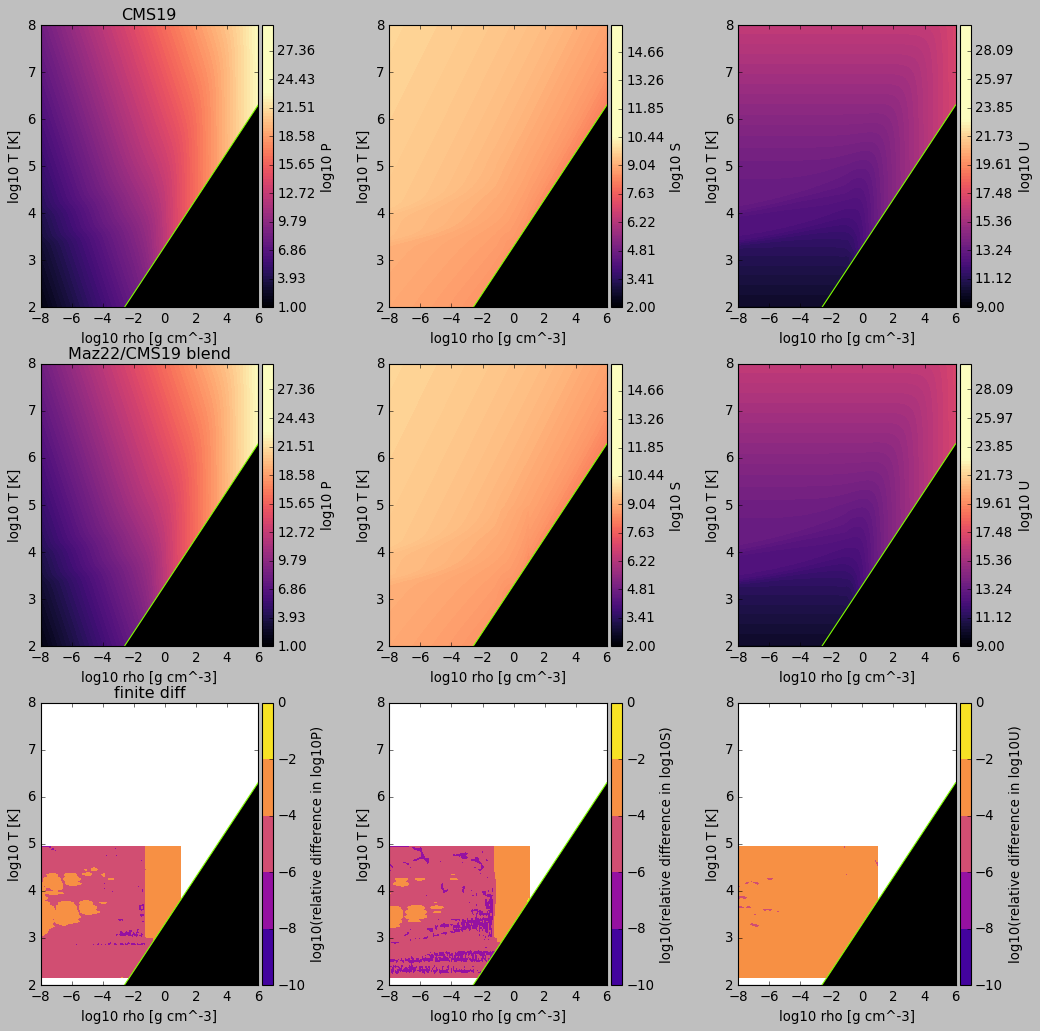

In [10]:
Plevels = np.linspace(1.,30., 100)
Pvmin = 1
Pvmax = 23.0

Slevels = np.linspace(2., 16., 200)
Svmin = 2
Svmax = 10.5

Ulevels = np.linspace(9., 30., 100)
Uvmin = 9.
Uvmax = 23.0

diffvmin = -10
diffvmax = -0.5
difflevels = np.linspace(diffvmin,0,6)


fig, axes = plt.subplots(3,3,figsize=(15,15))

# row 0: original CMS
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, cms_H.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, cms_H.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, cms_H.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: blend
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')


log10P_reldiff = np.log10(np.abs((cms_H.log10Pgrid - bln_H.log10Pgrid)/cms_H.log10Pgrid))
log10S_reldiff = np.log10(np.abs((cms_H.log10Sgrid - bln_H.log10Sgrid)/cms_H.log10Sgrid))
log10U_reldiff = np.log10(np.abs((cms_H.log10Ugrid - bln_H.log10Ugrid)/cms_H.log10Ugrid))

# row 2: finite diff
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, log10P_reldiff, levels=difflevels, cmap='plasma',alpha=1,vmin=diffvmin, vmax=diffvmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10(relative difference in log10P)')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, log10S_reldiff, levels=difflevels, cmap='plasma',alpha=1,vmin=diffvmin, vmax=diffvmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10(relative difference in log10S)')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, log10U_reldiff, levels=difflevels, cmap='plasma',alpha=1,vmin=diffvmin, vmax=diffvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10(relative difference in log10U)')

for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')

axes[0,0].set_title("CMS19")

axes[1,0].set_title("Maz22/CMS19 blend")
axes[2,0].set_title("finite diff")
plt.subplots_adjust(wspace=0.5)
#plt.show()

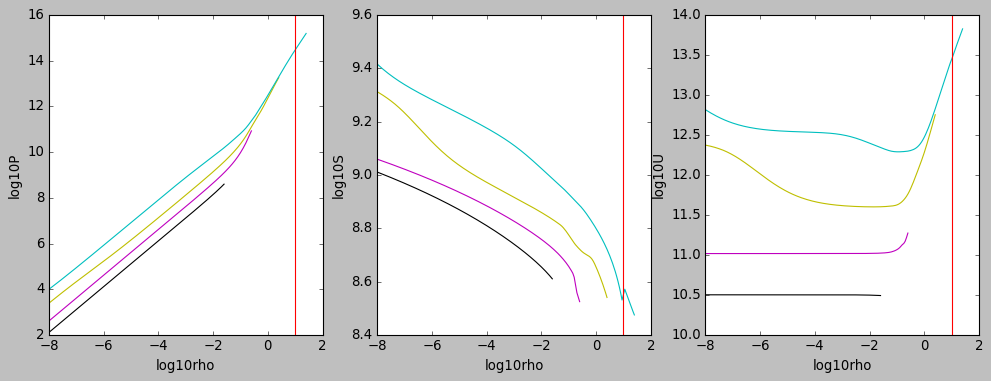

In [11]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(np.arange(-8,-1.55,0.05), bln_H.log10Pgrid[:129,10], 'k-') # log10T = 2.5
axes[0].plot(np.arange(-8,-0.55,0.05), bln_H.log10Pgrid[:149,20], 'm-') # log10T = 3
axes[0].plot(np.arange(-8,0.45,0.05), bln_H.log10Pgrid[:169,30], 'y-') # log10T = 3.5
axes[0].plot(np.arange(-8,1.45,0.05), bln_H.log10Pgrid[:189,40], 'c-') # log10T = 4
axes[0].set_ylabel('log10P')

axes[1].plot(np.arange(-8,-1.55,0.05), bln_H.log10Sgrid[:129,10], 'k-') # log10T = 2.5
axes[1].plot(np.arange(-8,-0.55,0.05), bln_H.log10Sgrid[:149,20], 'm-') # log10T = 3
axes[1].plot(np.arange(-8,0.45,0.05), bln_H.log10Sgrid[:169,30], 'y-') # log10T = 3.5
axes[1].plot(np.arange(-8,1.45,0.05), bln_H.log10Sgrid[:189,40], 'c-') # log10T = 4
axes[1].set_ylabel('log10S')

axes[2].plot(np.arange(-8,-1.55,0.05), bln_H.log10Ugrid[:129,10], 'k-') # log10T = 2.5
axes[2].plot(np.arange(-8,-0.55,0.05), bln_H.log10Ugrid[:149,20], 'm-') # log10T = 3
axes[2].plot(np.arange(-8,0.45,0.05), bln_H.log10Ugrid[:169,30], 'y-') # log10T = 3.5
axes[2].plot(np.arange(-8,1.45,0.05), bln_H.log10Ugrid[:189,40], 'c-') # log10T = 4
axes[2].set_ylabel('log10U')

for ax in axes:
    ax.axvline(1,color='r')
    ax.set_xlabel('log10rho')

plt.show()

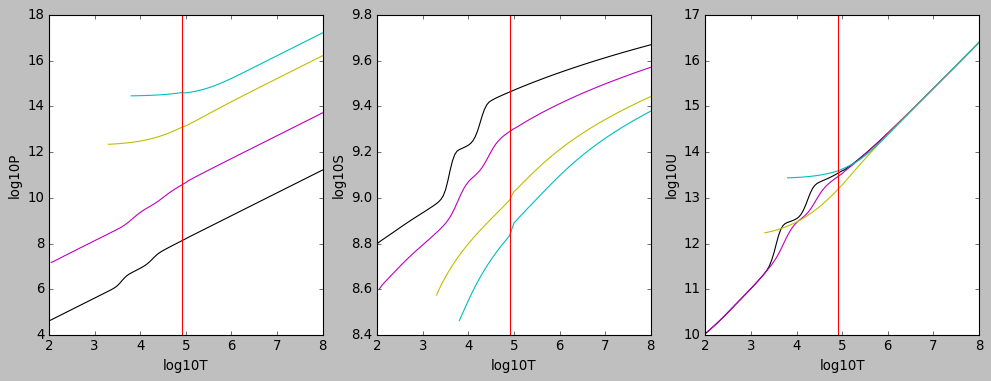

In [12]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(np.arange(2,8.01,0.05), bln_H.log10Pgrid[60], 'k-') # log10rho = -5
axes[0].plot(np.arange(2.05,8.01,0.05), bln_H.log10Pgrid[110,1:], 'm-') # log10rho = -2.5
axes[0].plot(np.arange(3.3,8.01,0.05), bln_H.log10Pgrid[160,26:], 'y-') # log10rho = 0
axes[0].plot(np.arange(3.8,8.01,0.05), bln_H.log10Pgrid[180,36:], 'c-') # log10rho = 1
axes[0].set_ylabel('log10P')

axes[1].plot(np.arange(2,8.01,0.05), bln_H.log10Sgrid[60], 'k-') # log10rho = -5
axes[1].plot(np.arange(2.05,8.01,0.05), bln_H.log10Sgrid[110,1:], 'm-') # log10rho = -2.5
axes[1].plot(np.arange(3.3,8.01,0.05), bln_H.log10Sgrid[160,26:], 'y-') # log10rho = 0
axes[1].plot(np.arange(3.8,8.01,0.05), bln_H.log10Sgrid[180,36:], 'c-') # log10rho = 1
axes[1].set_ylabel('log10S')

axes[2].plot(np.arange(2,8.01,0.05), bln_H.log10Ugrid[60], 'k-') # log10rho = -5
axes[2].plot(np.arange(2.05,8.01,0.05), bln_H.log10Ugrid[110,1:], 'm-') # log10rho = -2.5
axes[2].plot(np.arange(3.3,8.01,0.05), bln_H.log10Ugrid[160,26:], 'y-') # log10rho = 0
axes[2].plot(np.arange(3.8,8.01,0.05), bln_H.log10Ugrid[180,36:], 'c-') # log10rho = 1
axes[2].set_ylabel('log10U')

for ax in axes:
    ax.axvline(4.91,color='r')
    ax.set_xlabel('log10T')

plt.show()

# Boundaries of blend region look okay after very simple linear interpolation (just on the outermost row/columns). Could improve this step later if necessary by widening the linear interpolation region.

# calculate finite difference quantities between the grid points, then interpolate/extrapolate them to fall on the grid points

In [13]:
grid_rho = bln_H.log10rhogrid[:,0]
grid_T = bln_H.log10Tgrid[0]

between_rho = 0.5*(grid_rho[0:-1] + grid_rho[1:])
between_T = 0.5*(grid_T[0:-1] + grid_T[1:])

def interpolated_finite_difference_dlrho_T(table):
    """
    take the finite difference row-wise, i.e., wrt rho
    first we will get the values halfway between the rho grid points
    then we will use an interpolator to get them at the rho grid points
    """
   
    nrho, nT = np.shape(table.log10Tgrid)

    dlP_dlrho_T_btwn_rho_grid_points = np.zeros((nrho-1, nT))
    dlS_dlrho_T_btwn_rho_grid_points = np.zeros((nrho-1, nT))
    dlE_dlrho_T_btwn_rho_grid_points = np.zeros((nrho-1, nT))

    for i in range(nrho - 1): # number of unique rho values = 281
        dlP_dlrho_T_btwn_rho_grid_points[i] = (table.log10Pgrid[i+1] - table.log10Pgrid[i])/(table.log10rhogrid[i+1] - table.log10rhogrid[i])
        dlS_dlrho_T_btwn_rho_grid_points[i] = (table.log10Sgrid[i+1] - table.log10Sgrid[i])/(table.log10rhogrid[i+1] - table.log10rhogrid[i])
        dlE_dlrho_T_btwn_rho_grid_points[i] = (table.log10Ugrid[i+1] - table.log10Ugrid[i])/(table.log10rhogrid[i+1] - table.log10rhogrid[i])

    # bounds_error = False, fill_value = None should allow the entries on the edges of the grid to be extrapolated.
    interp_dlP_dlrho_T_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(between_rho, grid_T), values=dlP_dlrho_T_btwn_rho_grid_points, bounds_error=False, fill_value=None, method='cubic')
    interp_dlS_dlrho_T_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(between_rho, grid_T), values=dlS_dlrho_T_btwn_rho_grid_points, bounds_error=False, fill_value=None, method='cubic')
    interp_dlE_dlrho_T_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(between_rho, grid_T), values=dlE_dlrho_T_btwn_rho_grid_points, bounds_error=False, fill_value=None, method='cubic')

    dlP_dlrho_T = interp_dlP_dlrho_T_given_log10rho_log10T_cubic((table.log10rhogrid, table.log10Tgrid))
    dlS_dlrho_T = interp_dlS_dlrho_T_given_log10rho_log10T_cubic((table.log10rhogrid, table.log10Tgrid))
    dlE_dlrho_T = interp_dlE_dlrho_T_given_log10rho_log10T_cubic((table.log10rhogrid, table.log10Tgrid))
    
    return dlP_dlrho_T, dlS_dlrho_T, dlE_dlrho_T

def interpolated_finite_difference_dlT_rho(table):
    """
    take the finite difference column-wise, i.e., wrt T
    first we will get the values halfway between the T grid points
    then we will use an interpolator to get them at the T grid points
    """

    nrho, nT = np.shape(table.log10Tgrid)

    dlP_dlT_rho_btwn_rho_grid_points = np.zeros((nrho, nT-1))
    dlS_dlT_rho_btwn_rho_grid_points = np.zeros((nrho, nT-1))

    for j in range(nT - 1): # number of unique T values = 121
        dlP_dlT_rho_btwn_rho_grid_points[:,j] = (table.log10Pgrid[:,j+1] - table.log10Pgrid[:,j])/(table.log10Tgrid[:,j+1] - table.log10Tgrid[:,j])
        dlS_dlT_rho_btwn_rho_grid_points[:,j] = (table.log10Sgrid[:,j+1] - table.log10Sgrid[:,j])/(table.log10Tgrid[:,j+1] - table.log10Tgrid[:,j])

    # bounds_error = False, fill_value = None should allow the entries on the edges of the grid to be extrapolated.
    interp_dlP_dlT_rho_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(grid_rho, between_T), values=dlP_dlT_rho_btwn_rho_grid_points, bounds_error=False, fill_value=None, method='cubic')
    interp_dlS_dlT_rho_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(grid_rho, between_T), values=dlS_dlT_rho_btwn_rho_grid_points, bounds_error=False, fill_value=None, method='cubic')

    dlP_dlT_rho = interp_dlP_dlT_rho_given_log10rho_log10T_cubic((table.log10rhogrid, table.log10Tgrid))
    dlS_dlT_rho = interp_dlS_dlT_rho_given_log10rho_log10T_cubic((table.log10rhogrid, table.log10Tgrid))

    return dlP_dlT_rho, dlS_dlT_rho


# below are NOT LOGARITHMIC IN RHO or T !!!!
def interpolated_finite_difference_drho_T(table):
    """
    take the finite difference row-wise, i.e., wrt rho
    first we will get the values halfway between the rho grid points
    then we will use an interpolator to get them at the rho grid points
    """
   
    nrho, nT = np.shape(table.log10Tgrid)

    dS_drho_T_btwn_rho_grid_points = np.zeros((nrho-1, nT))
    dE_drho_T_btwn_rho_grid_points = np.zeros((nrho-1, nT))

    S = 10**table.log10Sgrid
    E = 10**table.log10Ugrid
    rho = 10**table.log10rhogrid

    # get rid of single inf value
    S[~np.isfinite(S)] = np.max(S[np.isfinite(S)])
    E[~np.isfinite(E)] = np.max(E[np.isfinite(E)])

    for i in range(nrho - 1): # number of unique rho values = 281
        dS_drho_T_btwn_rho_grid_points[i] = (S[i+1] - S[i])/(rho[i+1] - rho[i])
        dE_drho_T_btwn_rho_grid_points[i] = (E[i+1] - E[i])/(rho[i+1] - rho[i])

    # bounds_error = False, fill_value = None should allow the entries on the edges of the grid to be extrapolated.
    interp_dS_drho_T_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(between_rho, grid_T), values=dS_drho_T_btwn_rho_grid_points, bounds_error=False, fill_value=None, method='cubic')
    interp_dE_drho_T_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(between_rho, grid_T), values=dE_drho_T_btwn_rho_grid_points, bounds_error=False, fill_value=None, method='cubic')

    dS_drho_T = interp_dS_drho_T_given_log10rho_log10T_cubic((table.log10rhogrid, table.log10Tgrid))
    dE_drho_T = interp_dE_drho_T_given_log10rho_log10T_cubic((table.log10rhogrid, table.log10Tgrid))
    
    return dS_drho_T, dE_drho_T

def interpolated_finite_difference_dT_rho(table):
    """
    take the finite difference column-wise, i.e., wrt T
    first we will get the values halfway between the T grid points
    then we will use an interpolator to get them at the T grid points
    """

    nrho, nT = np.shape(table.log10Tgrid)

    dS_dT_rho_btwn_rho_grid_points = np.zeros((nrho, nT-1))

    S = 10**table.log10Sgrid
    T = 10**table.log10Tgrid

    # get rid of single inf value
    S[~np.isfinite(S)] = np.max(S[np.isfinite(S)])

    for j in range(nT - 1): # number of unique T values = 121
        dS_dT_rho_btwn_rho_grid_points[:,j] = (S[:,j+1] - S[:,j])/(T[:,j+1] - T[:,j])

    # bounds_error = False, fill_value = None should allow the entries on the edges of the grid to be extrapolated.
    interp_dS_dT_rho_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(grid_rho, between_T), values=dS_dT_rho_btwn_rho_grid_points, bounds_error=False, fill_value=None, method='cubic')

    dS_dT_rho = interp_dS_dT_rho_given_log10rho_log10T_cubic((table.log10rhogrid, table.log10Tgrid))

    return dS_dT_rho

In [14]:
bln_H.chiRho, bln_H.dlS_dlrho_T, bln_H.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(bln_H)
bln_H.chiT, bln_H.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(bln_H)

bln_H.dS_drho_T_direct, bln_H.dE_drho_T_direct = interpolated_finite_difference_drho_T(bln_H)
bln_H.dS_dT_rho_direct = interpolated_finite_difference_dT_rho(bln_H)

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/3607742825.py:75: RuntimeWarning: overflow encountered in power
  S = 10**table.log10Sgrid
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/3607742825.py:76: RuntimeWarning: overflow encountered in power
  E = 10**table.log10Ugrid
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/3607742825.py:107: RuntimeWarning: overflow encountered in power
  S = 10**table.log10Sgrid


In [15]:
# check for smoothness

# clearly there are some discontinuities, particularly in chiT, at the edge of the blended region. let's replace the outermost rows/column of the blended region with linearly interpolated values
chiRho_smoothed = copy.deepcopy(bln_H.chiRho)
dlS_dlrho_T_smoothed = copy.deepcopy(bln_H.dlS_dlrho_T)
dlE_dlrho_T_smoothed = copy.deepcopy(bln_H.dlE_dlrho_T)
chiT_smoothed = copy.deepcopy(bln_H.chiT)
dlS_dlT_rho_smoothed = copy.deepcopy(bln_H.dlS_dlT_rho)


rho_smoothing_width = 2

for ii, i in enumerate(range(180-rho_smoothing_width, 180+rho_smoothing_width+1)):
    chiRho_smoothed[i, 3:60] =  chiRho_smoothed[180 - rho_smoothing_width - 1, 3:60] + ((ii+1)/(2*rho_smoothing_width + 2))*(chiRho_smoothed[180 + rho_smoothing_width + 1, 3:60] - chiRho_smoothed[180 - rho_smoothing_width - 1, 3:60])
    dlS_dlrho_T_smoothed[i, 3:60] =  dlS_dlrho_T_smoothed[180 - rho_smoothing_width - 1, 3:60] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlS_dlrho_T_smoothed[180 + rho_smoothing_width + 1, 3:60] - dlS_dlrho_T_smoothed[180 - rho_smoothing_width - 1, 3:60])
    dlE_dlrho_T_smoothed[i, 3:60] =  dlE_dlrho_T_smoothed[180 - rho_smoothing_width - 1, 3:60] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlE_dlrho_T_smoothed[180 + rho_smoothing_width + 1, 3:60] - dlE_dlrho_T_smoothed[180 - rho_smoothing_width - 1, 3:60])
    
    chiT_smoothed[i, 3:60] =  chiT_smoothed[180 - rho_smoothing_width - 1, 3:60] + ((ii+1)/(2*rho_smoothing_width + 2))*(chiT_smoothed[180 + rho_smoothing_width + 1, 3:60] - chiT_smoothed[180 - rho_smoothing_width - 1, 3:60])
    dlS_dlT_rho_smoothed[i, 3:60] =  dlS_dlT_rho_smoothed[180 - rho_smoothing_width - 1, 3:60] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlS_dlT_rho_smoothed[180 + rho_smoothing_width + 1, 3:60] - dlS_dlT_rho_smoothed[180 - rho_smoothing_width - 1, 3:60])

T_smoothing_width = 2

for jj, j in enumerate(range(59-T_smoothing_width, 59+T_smoothing_width+1)):
    chiRho_smoothed[:181,j] = chiRho_smoothed[:181,59-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(chiRho_smoothed[:181,59+T_smoothing_width+1] - chiRho_smoothed[:181,59-T_smoothing_width - 1])
    dlS_dlrho_T_smoothed[:181,j] = dlS_dlrho_T_smoothed[:181,59-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlS_dlrho_T_smoothed[:181,59+T_smoothing_width+1] - dlS_dlrho_T_smoothed[:181,59-T_smoothing_width - 1])
    dlE_dlrho_T_smoothed[:181,j] = dlE_dlrho_T_smoothed[:181,59-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlE_dlrho_T_smoothed[:181,59+T_smoothing_width+1] - dlE_dlrho_T_smoothed[:181,59-T_smoothing_width - 1])
    
    chiT_smoothed[:181,j] = chiT_smoothed[:181,59-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(chiT_smoothed[:181,59+T_smoothing_width+1] - chiT_smoothed[:181,59-T_smoothing_width - 1])
    dlS_dlT_rho_smoothed[:181,j] = dlS_dlT_rho_smoothed[:181,59-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlS_dlT_rho_smoothed[:181,59+T_smoothing_width+1] - dlS_dlT_rho_smoothed[:181,59-T_smoothing_width - 1])
    
# for the lower T boundary, we're very close to the edge of the grid, so only smooth over 1 row to avoid using the extrapolated edge value in the smoothing
chiRho_smoothed[:181,3] = 0.5*(chiRho_smoothed[:181,2] + chiRho_smoothed[:181,4])
dlS_dlrho_T_smoothed[:181,3] = 0.5*(dlS_dlrho_T_smoothed[:181,2] + dlS_dlrho_T_smoothed[:181,4])
dlE_dlrho_T_smoothed[:181,3] = 0.5*(dlE_dlrho_T_smoothed[:181,2] + dlE_dlrho_T_smoothed[:181,4])

chiT_smoothed[:181,3] = 0.5*(chiT_smoothed[:181,2] + chiT_smoothed[:181,4])
dlS_dlT_rho_smoothed[:181,3] = 0.5*(dlS_dlT_rho_smoothed[:181,2] + dlS_dlT_rho_smoothed[:181,4])


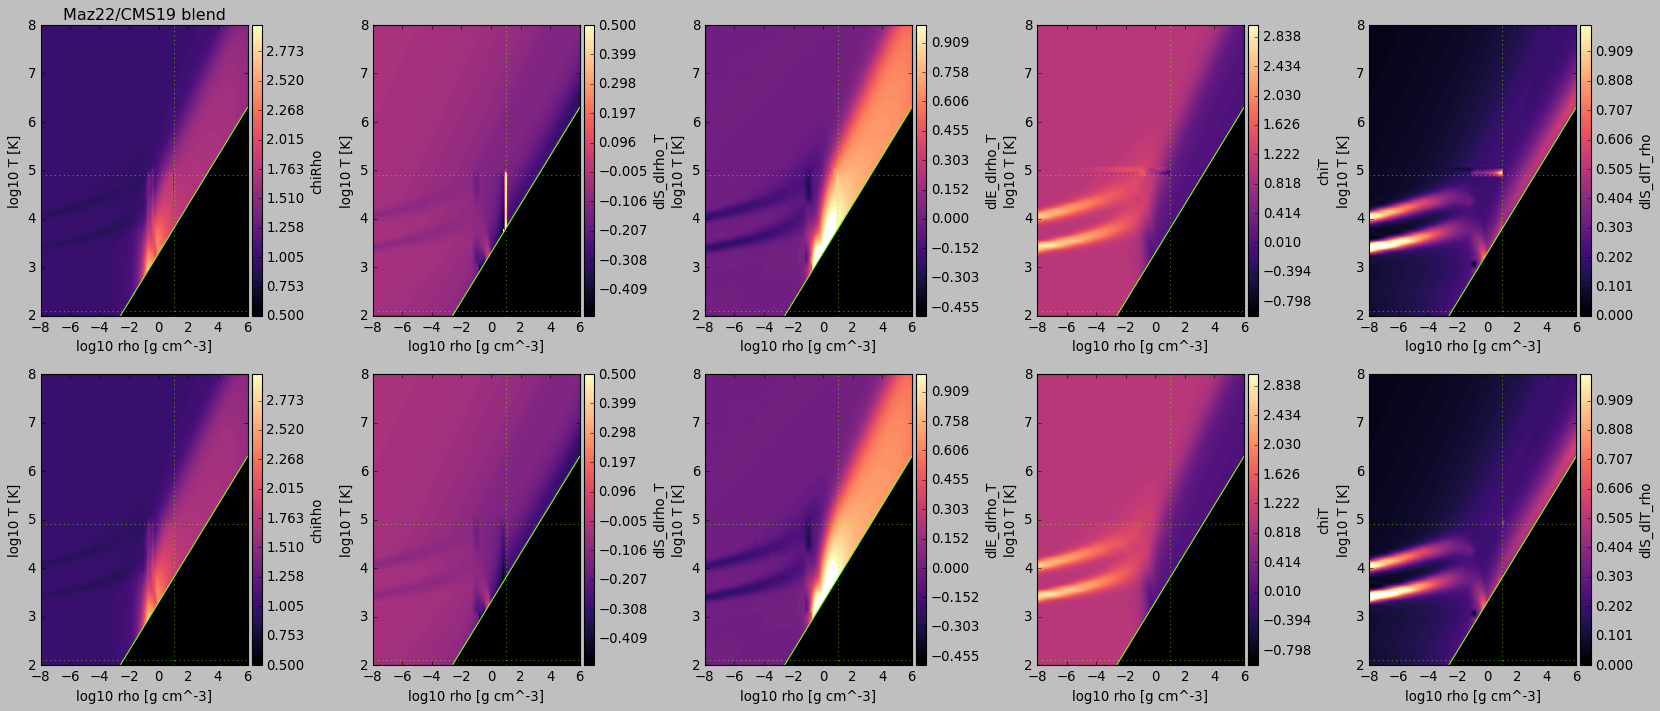

In [16]:
chiRho_vmin = 0.5
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -0.5
dlS_dlrho_T_vmax =0.5
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -0.5
dlE_dlrho_T_vmax =1
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)


chiT_vmin = -1
chiT_vmax = 3
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = 0
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from bln_H table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')




# row 1: interpolated finite difference quantities from bln_H table, with linearly smoothed edges of the blended region
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')


for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(1,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.1,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.91,color='#7FFF00',lw=0.5,ls=':')

axes[0,0].set_title("Maz22/CMS19 blend")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [17]:
# ok, satisfied with that smoothing for now--put it in the table object
bln_H.chiRho = chiRho_smoothed
bln_H.dlS_dlrho_T = dlS_dlrho_T_smoothed
bln_H.dlE_dlrho_T = dlE_dlrho_T_smoothed
bln_H.chiT = chiT_smoothed
bln_H.dlS_dlT_rho = dlS_dlT_rho_smoothed


# calculate MESA columns

## functions for fermi-dirac integral calculation (for degeneracy parameter, aka final column of mesa table)

In [18]:
def quad_fdk(k, eta):
    r = quad(lambda x: (x)**(k)/(1.+np.exp(x-eta)),
            0, np.inf,epsabs=1e-300,epsrel=1e-8,limit=100)
    return r[0], r[1]

def quad_gfdk(k, eta, theta):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        def func(x):
            return (x)**(k)*np.sqrt(1+theta*x/2.)/(1.+np.exp(x-eta))
        # first derivative of the above. note: this only holds if k>0 (true in our case, k=0.5)
        # see Fukushima 2015 "Precise and fast computation of Fermi-Dirac integral of
        #  integer and half integer order by piecewise minimax rational approximation"
        def dfunc(x):
            return k*(x)**(k-1)*np.sqrt(1+theta*x/2.)/(1.+np.exp(x-eta))
    r = quad(func, 0, np.inf,epsabs=1e-300,epsrel=1e-8,limit=100)
    dr = quad(dfunc, 0, np.inf,epsabs=1e-300,epsrel=1e-8,limit=100)
    return r[0], dr[0]


h = 6.62607015e-27 # erg/s
m_e = 9.1093837015e-28 #g
c = 2.99792458e10 #cm/s
kB = 1.380649e-16 #erg/K
m_p = 1.6605e-24 #g/amu

def fdint_abs_diff(eta_test, theta, fdint_to_match):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fdint_test, dfdint_test = quad_gfdk(0.5, eta_test, theta)
    return np.abs(fdint_to_match - fdint_test) #, dfdint_test

def solve_fdint(rhs, theta, eta0 = -0.01):
    #opt = optimize.minimize(fdint_abs_diff, x0=eta0, args=(theta,rhs), jac=True, bounds=[(-1000.,1000.)],tol=1.e-10)
    opt = optimize.minimize(fdint_abs_diff, x0=eta0, args=(theta,rhs), bounds=[(-1000.,1000.)],tol=1.e-10)
    opt_eta = opt.x[0]
    #print(opt.success)
    #print(opt.message)
    return opt_eta

In [19]:
#n_e_med = 6.022282445046672e+22 #e-/cm^3
#T_med = 1.e5 #K

#theta_med = (kB*T_med)/(m_e*c**2)
#print(theta_med)

#rhs = (n_e_med * h**3)/(4*np.pi*(2*m_e*kB*T_med)**(3./2.))
#print(rhs)
#opt_eta_ = solve_fdint(rhs=rhs)
#print(opt_eta_)

#print(quad_gfdk(0.5,opt_eta_,theta_med))

#rel_err = np.abs(rhs - quad_gfdk(0.5,opt_eta_,theta_med)[0])/rhs
#print(rel_err)

In [20]:
def MESA_cols_6to16(table, X=1, Y=0):
    """
    this assumes that the following attributes are already defined:
    table.log10Tgrid
    table.log10rhogrid
    table.log10Pgrid
    table.log10Ugrid
    table.log10Sgrid
    table.chiRho
    table.dlS_dlrho_T
    table.chiT
    table.dlS_dlT_rho

    and that the remainder of the MESA columns already exist in the table object, they just currently equal None.
    """
    S = 10**table.log10Sgrid #erg g^-1 K^-1
    rho = 10**table.log10rhogrid # g cm^-3
    E = 10**table.log10Ugrid # erg g^-1
    T = 10**table.log10Tgrid # K

    dlrho_dlT_P = -1. * table.chiT/table.chiRho
    dlrho_dlP_T = 1./table.chiRho 

    dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
    dlS_dlP_T = table.dlS_dlrho_T/table.chiRho

    table.grad_ad = -1.* table.dlS_dlrho_T/((table.chiRho*table.dlS_dlT_rho) - (table.chiT*table.dlS_dlrho_T))
    
    table.Cp = S * dlS_dlT_P
    table.Cv = S * table.dlS_dlT_rho

    table.dE_drho_T = table.dlE_dlrho_T * (E/rho) #dE/drho = (dlE/dlrho) * (E/rho)
    table.dS_dT_rho = table.dlS_dlT_rho * (S/T) #dS/dT = (dlS/dlT) * (S/T)
    table.dS_drho_T = table.dlS_dlrho_T * (S/rho) #dS/drho = (dlS/dlrho) * (S/rho)

    table.mu = (4./(6*X + 4*Y + 2))*np.ones_like(table.log10Tgrid)
    table.log_free_e = np.log10(0.5*(1+X))*np.ones_like(table.log10Tgrid) # = 1/mu_e 
    
    table.gamma3 = (-1. * (table.dlS_dlrho_T/table.dlS_dlT_rho)) + 1.
    table.gamma1 = table.chiT*(table.gamma3 - 1.) + table.chiRho
    
    table.eta = np.zeros_like(table.log10Tgrid)

    for i in range(np.shape(table.log10Tgrid)[1]):
        print(table.log10Tgrid[1][i])
        for j in range(np.shape(table.log10rhogrid)[0]):
            this_recip_mu_e = (10**table.log_free_e[j,i])
            this_n_e = 10**table.log10rhogrid[j,i] * this_recip_mu_e * (1/m_p) # g/cm^3 * e-/amu * amu/g = e-/cm^3
            this_T = 10**table.log10Tgrid[j,i]
            rhs = (this_n_e * h**3)/(4*np.pi*(2*m_e*kB*this_T)**(3./2.))
            theta = (kB*this_T)/(m_e*c**2)

            # if too few free e-, then just set eta to an arbitrary low value (same thing is done in MESA EoS code)
            if table.log_free_e[j,i]  <= -4:
                opt_eta_ = -20
            else:
                #print("")
                #print(this_n_e)
                #print(this_T)
                #print(theta)
                #print(rhs)
                opt_eta_ = solve_fdint(rhs=rhs,theta=theta)
            table.eta[j,i] = opt_eta_

    return

In [21]:
start = time.time()
MESA_cols_6to16(bln_H,X=1,Y=0)
end = time.time()
print((end-start)/60.)

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:16: RuntimeWarning: overflow encountered in power
  S = 10**table.log10Sgrid #erg g^-1 K^-1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:18: RuntimeWarning: overflow encountered in power
  E = 10**table.log10Ugrid # erg g^-1


2.0
2.05
2.1
2.15
2.2
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05
4.1
4.15
4.2
4.25
4.3
4.35
4.4
4.45
4.5
4.55
4.6
4.65
4.7
4.75
4.8
4.85
4.9
4.95
5.0
5.05
5.1
5.15
5.2
5.25
5.3
5.35
5.4
5.45
5.5
5.55
5.6
5.65
5.7
5.75
5.8
5.85
5.9
5.95
6.0
6.05
6.1
6.15
6.2
6.25
6.3
6.35
6.4
6.45
6.5
6.55
6.6
6.65
6.7
6.75
6.8
6.85
6.9
6.95
7.0
7.05
7.1
7.15
7.2
7.25
7.3
7.35
7.4
7.45
7.5
7.55
7.6
7.65
7.7
7.75
7.8
7.85
7.9
7.95
8.0
133.4401612798373


6.022282445046672e+22


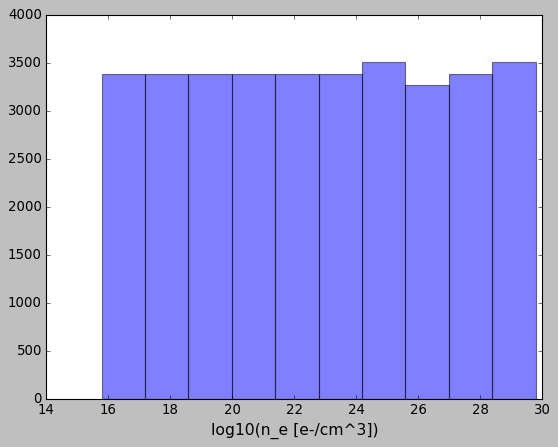

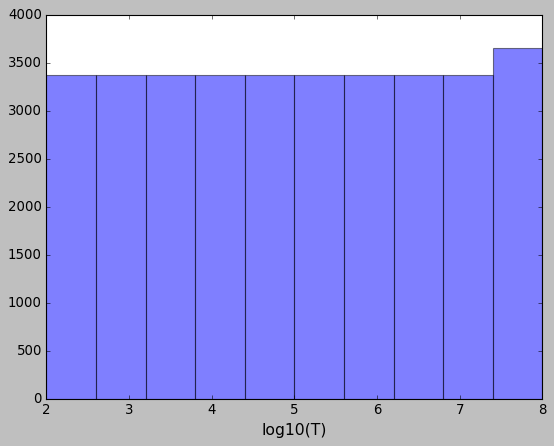

In [22]:
recip_mu_e = (10**bln_H.log_free_e)

m_p = 1.6605e-24 #g/amu
n_e = 10**bln_H.log10rhogrid * recip_mu_e * (1/m_p) # g/cm^3 * e-/amu * amu/g = e-/cm^3
n_e = np.ravel(n_e)
print(np.median(n_e))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.hist(np.log10(n_e),color='b',alpha=0.5)
ax.set_xlabel('log10(n_e [e-/cm^3])',fontsize=14)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.hist(np.ravel(bln_H.log10Tgrid),color='b',alpha=0.5)
ax.set_xlabel('log10(T)',fontsize=14)
plt.show()

## compare dE_drho_T, dS_drho_T, dS_dT_rho calculated via direct finite difference to those calculated from finite difference of the log quantities

(281,)


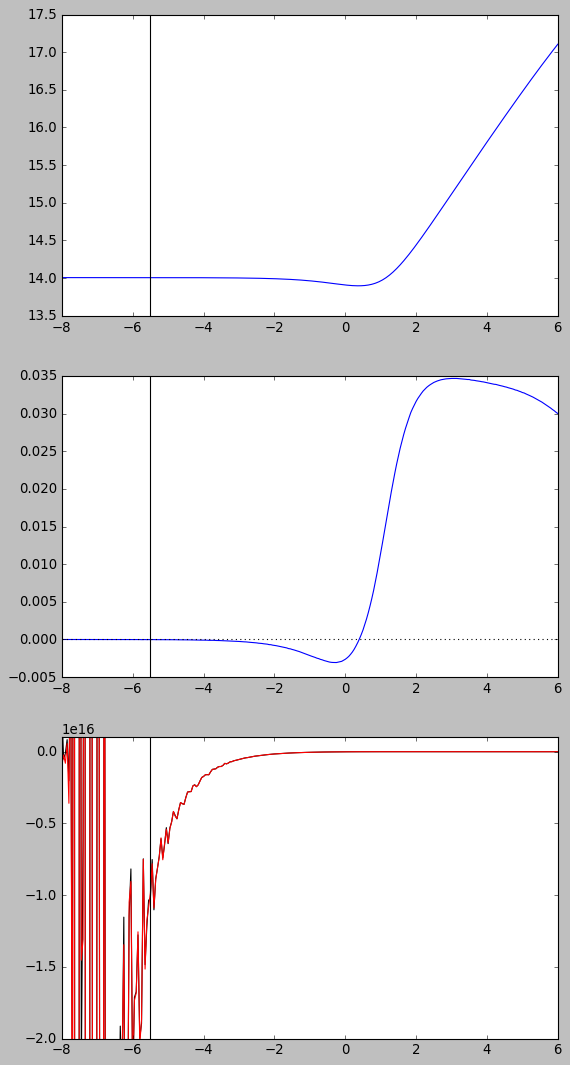

In [23]:
print(np.shape(bln_H.log10Ugrid[:,0]))
#print(bln_H.log10Ugrid[:,-1])
#print(bln_H.log10Tgrid[:,-50])
fig, axes = plt.subplots(3,1,figsize=(8,16))
#ax.plot(bln_H.log10Ugrid[:,-1])
axes[0].plot(bln_H.log10rhogrid[:,-50],bln_H.log10Ugrid[:,-50])
axes[1].plot(bln_H.log10rhogrid[1:,-50],bln_H.log10Ugrid[1:,-50]-bln_H.log10Ugrid[:-1,-50])
axes[1].axhline(0,color='k',ls=':')
axes[2].plot(bln_H.log10rhogrid[:,-50],bln_H.dE_drho_T_direct[:,-50],'k-')
axes[2].plot(bln_H.log10rhogrid[:,-50],bln_H.dE_drho_T[:,-50],'r-')
axes[2].set_ylim(-2.e16,1.e15)
for ax in axes:
    ax.axvline(-5.5,color='k')
plt.show()

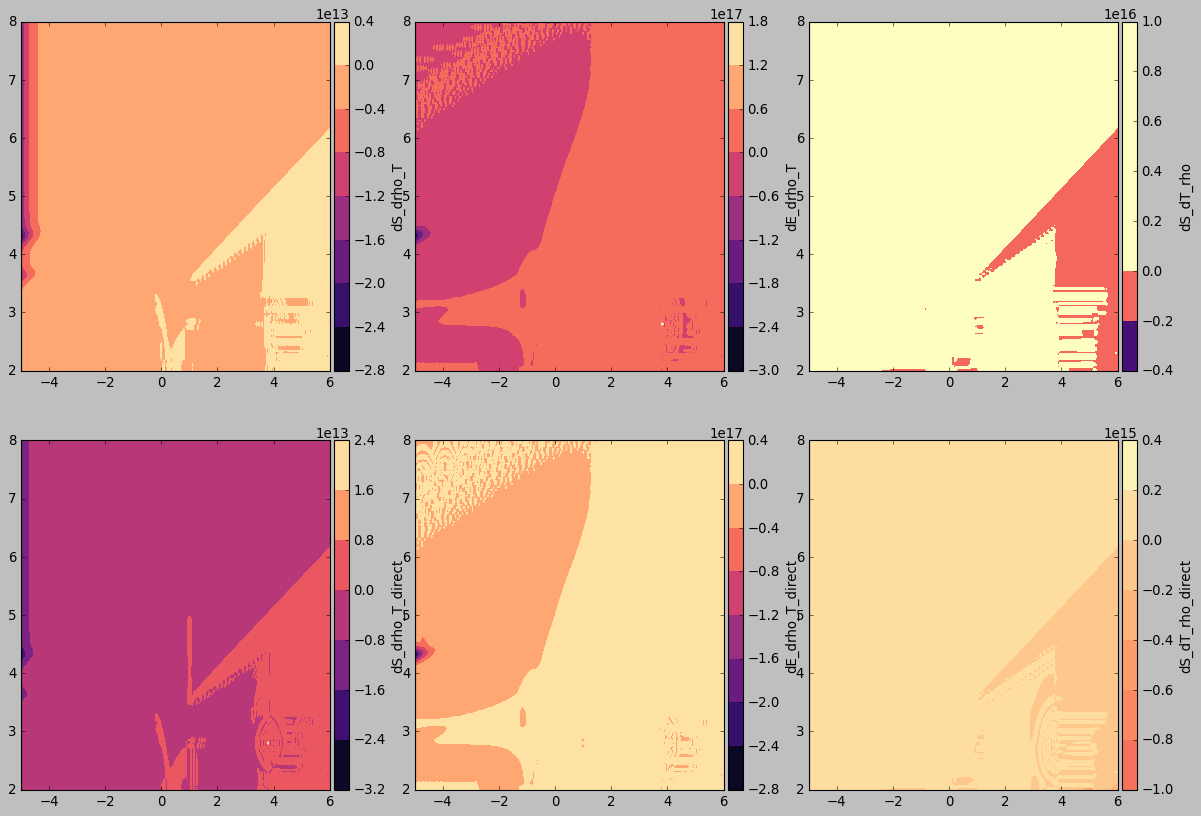

In [24]:
fig, axes = plt.subplots(2,3,figsize=(18,12))

divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(bln_H.log10rhogrid[60:], bln_H.log10Tgrid[60:], bln_H.dS_drho_T[60:], cmap='magma')
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='dS_drho_T')

divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(bln_H.log10rhogrid[60:], bln_H.log10Tgrid[60:], bln_H.dS_drho_T_direct[60:], cmap='magma')
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='dS_drho_T_direct')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(bln_H.log10rhogrid[60:], bln_H.log10Tgrid[60:], bln_H.dE_drho_T[60:], cmap='magma')
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dE_drho_T')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(bln_H.log10rhogrid[60:], bln_H.log10Tgrid[60:], bln_H.dE_drho_T_direct[60:], cmap='magma')
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dE_drho_T_direct')


divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(bln_H.log10rhogrid[60:], bln_H.log10Tgrid[60:], bln_H.dS_dT_rho[60:], cmap='magma',vmin=-0.4e16,vmax=0.4e15)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dS_dT_rho')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(bln_H.log10rhogrid[60:], bln_H.log10Tgrid[60:], bln_H.dS_dT_rho_direct[60:], cmap='magma',vmin=-0.4e16,vmax=0.4e15)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dS_dT_rho_direct')

for ax in np.ravel(axes):
    ax.axvline(-5,color='k')

plt.show()


# put table in MESA format and write file

In [25]:
# example MESA table format
#       version             X             Z     num logTs      logT min      logT max      del logT     num logQs      logQ min      logQ max      del logQ
#            51        1.0000        0.0000       306            2.1000        8.2000        0.0200       527          -10.0900        5.6900        0.0300
#
#       logQ = logRho - 2*logT + 12
#      -10.090000
#
#logT   logPgas      logE      logS       chiRho         chiT           Cp           Cv      dE_dRho        dS_dT      dS_dRho      mu  log_free_e   gamma1    gamma3   grad_ad       eta
#2.10  -4.28120   9.90528   9.17145  9.88041E-01  1.03588E+00  1.14092E+08  6.83968E+07 -1.90043E+22  5.43295E+05 -4.35851E+21  0.50000 -99.00000   1.64814   1.63724   0.38664  -20.00000
#2.12  -4.26120   9.92680   9.17238  9.86293E-01  1.04112E+00  1.15614E+08  6.92914E+07 -2.28483E+22  5.25629E+05 -4.38833E+21  0.50000 -99.00000   1.64565   1.63332   0.38484  -20.00000
#2.14  -4.24120   9.94854   9.17332  9.84294E-01  1.04712E+00  1.17367E+08  7.03185E+07 -2.74696E+22  5.09413E+05 -4.42257E+21  0.50000 -99.00000   1.64286   1.62893   0.38283  -20.00000
#2.16  -4.22120   9.97052   9.17427  9.82010E-01  1.05397E+00  1.19386E+08  7.14978E+07 -3.30258E+22  4.94644E+05 -4.46188E+21  0.50000 -99.00000   1.63975   1.62406   0.38058  -20.00000
# ...
#8.16  10.61086  24.28885  16.25379  3.70795E-08  4.00000E+00  1.93516E+24  5.38162E+16 -1.14513E+30  3.72317E+08 -1.05631E+22  0.50000  -0.00000   1.33333   1.33333   0.25000  -22.87334
#8.18  10.67087  24.32885  16.27379  3.54107E-08  4.00000E+00  2.12187E+24  5.63525E+16 -1.14513E+30  3.72317E+08 -1.00877E+22  0.50000  -0.00000   1.33333   1.33333   0.25000  -22.85238
#8.20  10.73087  24.36885  16.29379  3.38169E-08  4.00000E+00  2.32658E+24  5.90083E+16 -1.14513E+30  3.72317E+08 -9.63367E+21  0.50000   0.00000   1.33333   1.33333   0.25000  -22.83155
#
#
#       logQ = logRho - 2*logT + 12
#      -10.060000
#
#logT   logPgas      logE      logS       chiRho         chiT           Cp           Cv      dE_dRho        dS_dT      dS_dRho      mu  log_free_e   gamma1    gamma3   grad_ad       eta
#2.10  -4.28120   9.90528   9.17145  9.88041E-01  1.03588E+00  1.14092E+08  6.83968E+07 -1.90043E+22  5.43295E+05 -4.35851E+21  0.50000 -99.00000   1.64814   1.63724   0.38664  -20.00000
#2.12  -4.26120   9.92680   9.17238  9.86293E-01  1.04112E+00  1.15614E+08  6.92914E+07 -2.28483E+22  5.25629E+05 -4.38833E+21  0.50000 -99.00000   1.64565   1.63332   0.38484  -20.00000
#2.14  -4.24120   9.94854   9.17332  9.84294E-01  1.04712E+00  1.17367E+08  7.03185E+07 -2.74696E+22  5.09413E+05 -4.42257E+21  0.50000 -99.00000   1.64286   1.62893   0.38283  -20.00000
#2.16  -4.22120   9.97052   9.17427  9.82010E-01  1.05397E+00  1.19386E+08  7.14978E+07 -3.30258E+22  4.94644E+05 -4.46188E+21  0.50000 -99.00000   1.63975   1.62406   0.38058  -20.00000


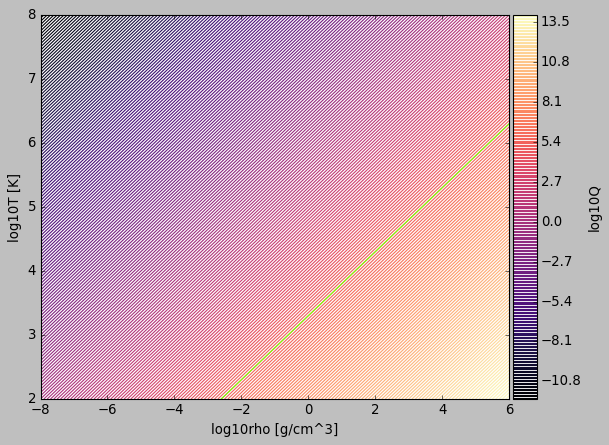

In [26]:
Qvmin= -12
Qvmax = 14
Qlevels = np.arange(Qvmin, Qvmax+0.05, 0.1)

fig, ax = plt.subplots(1,1,figsize=(8,6))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cs = ax.contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Qgrid, levels=Qlevels, cmap='magma',alpha=1,vmin=Qvmin, vmax=Qvmax)
fig.colorbar(cs, cax=cax, orientation='vertical',label='log10Q')

ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
ax.set_xlim(-8,6)
ax.set_ylim(2,8)
ax.set_xlabel('log10rho [g/cm^3]')
ax.set_ylabel('log10T [K]')
plt.show()

In [27]:
def format_e(n):
    a = '%E' % n
    #print(a)
    firsthalf = a.split('E')[0].rstrip('0').rstrip('.')
    firsthalf = firsthalf[0:7]
    #print(firsthalf)
    return firsthalf + 'E' + a.split('E')[1]


In [162]:
def write_MESA_table(table, outfilename, version=1, X=1.0, Z=0.0):
    """
    Convert a table in (T, rho) grid format into MESA's bizarre (T, Q) format and save to file.
    """
    Tarr = np.unique(table.log10Tgrid)
    numlogTs = len(Tarr)
    logTmin = np.min(Tarr)
    logTmax = np.max(Tarr)
    dellogT = Tarr[1] - Tarr[0]

    # only use Qs <= 5.4, because this is the value that corresponds to the boundary between physical and unphysical values in the CMS pure H table
    Qarr = np.unique(np.round(table.log10Qgrid[table.log10Qgrid <= 5.4],6))
    numlogQs = len(Qarr)
    logQmin = np.min(Qarr)
    logQmax = np.max(Qarr)
    dellogQ = Qarr[1] - Qarr[0]
    
    header0keys = ['version','X','Z','num logTs','logT min','logT max','del logT','num logQs','logQ min','logQ max','del logQ']
    header0vals = [version,X,Z,numlogTs,logTmin,logTmax,dellogT,numlogQs,logQmin,logQmax,dellogQ]

    header0=""
    for k in header0keys:
        kstr = '{:>14}'.format(k)
        header0 = header0 + kstr

    header1=""
    for v in header0vals:
        vstr = '{:>14}'.format(str(np.round(v,6)))
        header1 = header1 + vstr

    header2keys =['logT','logPgas','logE','logS','chiRho','chiT','Cp','Cv','dE_dRho','dS_dT','dS_dRho','mu ','log_free_e','gamma1','gamma3','grad_ad','eta']

    with open(outfilename, 'w') as outfile:
        outfile.write(header0)
        outfile.write('\n')
        outfile.write(header1)
        outfile.write('\n')

        for i, logQ in enumerate(Qarr):
            #print(logQ)
            outfile.write('\n')
            outfile.write('       logQ = logRho - 2*logT + 12')
            outfile.write('\n')
            logQstr = f"{np.round(logQ,6):#.4g}"
            logQstr = logQstr.split(".")[0] + '.' + logQstr.split(".")[1][0:2]
            outfile.write('{:>12}'.format(logQstr))
            outfile.write('\n')
            outfile.write('\n')
            header2=''
            for l, key in enumerate(header2keys):
                if l==0:
                    kstr = key
                elif l > 0 and l <= 3:
                    kstr = '{:>10}'.format(key)
                elif l > 3 and l <= 10:
                    kstr = '{:>14}'.format(key)
                else:
                    kstr = '{:>10}'.format(key)    
                header2 = header2 + kstr
            outfile.write(header2)
            outfile.write('\n')

            # write data here

            # get columns
            # attributes are named:
            # log10Qgrid, log10Tgrid, log10Pgrid, log10Ugrid, log10Sgrid, chiRho, chiT, Cp, Cv, dE_drho_T, dS_dT_rho, dS_drho_T, mu, log_free_e, gamma1, gamma3, grad_ad, eta
            # every one of them is a (281, 121) array (281 rho values, 121 T values)

            thisQmask = (np.round(table.log10Qgrid,6) == logQ)

            for j in range(np.shape(table.log10Qgrid[thisQmask])[0]):
                rowList = [table.log10Tgrid[thisQmask][j], 
                           table.log10Pgrid[thisQmask][j],
                           table.log10Ugrid[thisQmask][j],
                           table.log10Sgrid[thisQmask][j],
                           table.chiRho[thisQmask][j],
                           table.chiT[thisQmask][j],
                           table.Cp[thisQmask][j], 
                           table.Cv[thisQmask][j],
                           table.dE_drho_T[thisQmask][j],
                           table.dS_dT_rho[thisQmask][j],
                           table.dS_drho_T[thisQmask][j],
                           table.mu[thisQmask][j],
                           table.log_free_e[thisQmask][j], 
                           table.gamma1[thisQmask][j],
                           table.gamma3[thisQmask][j],
                           table.grad_ad[thisQmask][j],
                           table.eta[thisQmask][j],
                          ]
                           
                rowStr=""
                # from here: want different formatting for the different columns, actually 
                #logT   logPgas      logE      logS       chiRho         chiT           Cp           Cv      dE_dRho        dS_dT      dS_dRho      mu  log_free_e   gamma1    gamma3   grad_ad       eta
                #2.10  -4.28120   9.90528   9.17145  9.88041E-01  1.03588E+00  1.14092E+08  6.83968E+07 -1.90043E+22  5.43295E+05 -4.35851E+21  0.50000 -99.00000   1.64814   1.63724   0.38664  -20.00000

                for k, r in enumerate(rowList):
                    if k == 0:
                        rstr = "{:.2f}".format(r)
                    elif k > 0 and k <= 3:
                        rstr = ' ' + "{:.5f}".format(r)
                        rstr = '{:>10}'.format(rstr)
                    elif k > 3 and k <= 10:
                        try:
                            rstr = ' ' + format_e(r)
                        except IndexError:
                            print(k,header2keys[k],r,np.sign(r))
                            if k==6:
                                if np.sign(r) < 0.:
                                    rfinite = np.min(table.Cp[np.isfinite(table.Cp)])
                                else:
                                    rfinite = np.max(table.Cp[np.isfinite(table.Cp)])
                            rstr = ' ' + format_e(rfinite)
                            
                        rstr = '{:>14}'.format(rstr)
                    else:
                        rstr = ' ' + "{:.5f}".format(r)
                        rstr = '{:>10}'.format(rstr)
                    
                    rowStr = rowStr + rstr
                    
                outfile.write(rowStr)
                outfile.write('\n')

            
            outfile.write('\n')
            outfile.write('\n')

    
    return

In [29]:
write_MESA_table(bln_H, './my_MESAformat_tables/mesa-CMS_100x.data',version=1, X=1.0, Z=0.0)

# Write the pure He table in MESA format.

In [30]:
cms_He = meos.CMStable("./2021_chabrier+_tables/TABLE_HE_Trho_v1",units='cgs')

cms_He_attr_list = dir(cms_He)

cms_He_attr_list_filtered = []
for i, li in enumerate(cms_He_attr_list):
    if li[0] != "_":
        cms_He_attr_list_filtered.append(li)
        
print(cms_He_attr_list_filtered)

# cms_He is (T, rho)
#  log10T ranges from 2. to 8. in steps of 0.05 (121 entries)
#  log10rho ranges from -8. to 6. in steps of 0.05 (281 entries)

['Cp', 'Cv', 'X', 'Y', 'atomic_number', 'chiRho', 'chiT', 'dE_drho_T', 'dE_drho_T_direct', 'dS_dT_rho', 'dS_dT_rho_direct', 'dS_drho_T', 'dS_drho_T_direct', 'dlE_dlrho_T', 'dlS_dlP_T_grid', 'dlS_dlT_P_grid', 'dlS_dlT_rho', 'dlS_dlrho_T', 'dlrho_dlP_T_grid', 'dlrho_dlT_P_grid', 'eosData', 'eta', 'filename', 'gamma1', 'gamma3', 'grad_ad', 'grad_ad_grid', 'independent_arr_1', 'independent_arr_2', 'independent_var_1', 'independent_var_2', 'log10Pgrid', 'log10Qgrid', 'log10Sgrid', 'log10Tgrid', 'log10Ugrid', 'log10rhogrid', 'log_free_e', 'mass_number', 'mu', 'units']


In [31]:
'''
# linearly interpolate over the column log10rho = 2 and the row log10T = 6
E_smoothed = copy.deepcopy(cms_He.log10Ugrid)
S_smoothed = copy.deepcopy(cms_He.log10Sgrid)

rho_smoothing_width = 1

for ii, i in enumerate(range(200-rho_smoothing_width, 200+rho_smoothing_width+1)):
    E_smoothed[i, 40:80] =  E_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(E_smoothed[200 + rho_smoothing_width + 1, 40:80] - E_smoothed[200 - rho_smoothing_width - 1, 40:80])
    S_smoothed[i, 40:80] =  S_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(S_smoothed[200 + rho_smoothing_width + 1, 40:80] - S_smoothed[200 - rho_smoothing_width - 1, 40:80])
    
T_smoothing_width = 1

for jj, j in enumerate(range(80-T_smoothing_width, 80+T_smoothing_width+1)):
    E_smoothed[140:200,j] = E_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(E_smoothed[140:200,80+T_smoothing_width+1] - E_smoothed[140:200,80-T_smoothing_width - 1])
    S_smoothed[140:200,j] = S_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(S_smoothed[140:200,80+T_smoothing_width+1] - S_smoothed[140:200,80-T_smoothing_width - 1])


Slevels = np.linspace(8., 10.5, 30)
Svmin = 8
Svmax = 10.5

Elevels = np.linspace(6.5, 18, 30)
Evmin = 6.5
Evmax = 18


fig, axes = plt.subplots(2,2,figsize=(10,10))

# row 0: interpolated finite difference quantities from cms_He table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10S')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Ugrid, levels=Elevels, cmap='magma',alpha=1,vmin=Evmin, vmax=Evmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10E')


# row 1: interpolated finite difference quantities from cms_He table, with linearly smoothed edges of the QMD region (particularly over the horizontal line log10T = 6 and the vertical line log10rho = 2)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, S_smoothed, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10S')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, E_smoothed, levels=Elevels, cmap='magma',alpha=1,vmin=Evmin, vmax=Evmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10E')

for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(-1,color='#7FFF00',lw=0.5,ls=':')
    ax.axvline(2,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.3,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(6,color='#7FFF00',lw=0.5,ls=':')
    
    #to plot any contour log10Q = Q:
    # plot y = (x/2) + (12-Q)/2
    Qplot = 4.25
    ax.plot(np.linspace(-8,6,50), (1./2.)*np.linspace(-8,6,50) + (12-Qplot)/2, ls='-', color='b')

axes[0,0].set_title("CMS19 He")
plt.subplots_adjust(wspace=0.5)
plt.show()

# try this smoothing and see what effect it has on the derivatives
cms_He.log10Sgrid = S_smoothed
cms_He.log10Ugrid = E_smoothed
'''

'\n# linearly interpolate over the column log10rho = 2 and the row log10T = 6\nE_smoothed = copy.deepcopy(cms_He.log10Ugrid)\nS_smoothed = copy.deepcopy(cms_He.log10Sgrid)\n\nrho_smoothing_width = 1\n\nfor ii, i in enumerate(range(200-rho_smoothing_width, 200+rho_smoothing_width+1)):\n    E_smoothed[i, 40:80] =  E_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(E_smoothed[200 + rho_smoothing_width + 1, 40:80] - E_smoothed[200 - rho_smoothing_width - 1, 40:80])\n    S_smoothed[i, 40:80] =  S_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(S_smoothed[200 + rho_smoothing_width + 1, 40:80] - S_smoothed[200 - rho_smoothing_width - 1, 40:80])\n    \nT_smoothing_width = 1\n\nfor jj, j in enumerate(range(80-T_smoothing_width, 80+T_smoothing_width+1)):\n    E_smoothed[140:200,j] = E_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(E_smoothed[140:200,80+T_smoothing_width+1] - E_smoothed[140:

In [32]:
cms_He.chiRho, cms_He.dlS_dlrho_T, cms_He.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(cms_He)
cms_He.chiT, cms_He.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(cms_He)

#cms_He.dS_drho_T_direct, cms_He.dE_drho_T_direct = interpolated_finite_difference_drho_T(cms_He)
#cms_He.dS_dT_rho_direct = interpolated_finite_difference_dT_rho(cms_He)

In [33]:
'''
print(np.shape(cms_He.log10Ugrid[:,0]))
#print(cms_He.log10Ugrid[:,-1])
#print(cms_He.log10Tgrid[:,-50])
fig, axes = plt.subplots(3,1,figsize=(8,16))
#ax.plot(cms_He.log10Ugrid[:,-1])
axes[0].plot(cms_He.log10rhogrid[:,-50],cms_He.log10Ugrid[:,-50])
axes[1].plot(cms_He.log10rhogrid[1:,-50],cms_He.log10Ugrid[1:,-50]-cms_He.log10Ugrid[:-1,-50])
axes[1].axhline(0,color='k',ls=':')
axes[2].plot(cms_He.log10rhogrid[:,-50],cms_He.dE_drho_T_direct[:,-50],'k-')
axes[2].plot(cms_He.log10rhogrid[:,-50],cms_He.dE_drho_T[:,-50],'r-')
axes[2].set_ylim(-2.e16,1.e15)
for ax in axes:
    ax.axvline(-5.5,color='k')
plt.show()
'''

"\nprint(np.shape(cms_He.log10Ugrid[:,0]))\n#print(cms_He.log10Ugrid[:,-1])\n#print(cms_He.log10Tgrid[:,-50])\nfig, axes = plt.subplots(3,1,figsize=(8,16))\n#ax.plot(cms_He.log10Ugrid[:,-1])\naxes[0].plot(cms_He.log10rhogrid[:,-50],cms_He.log10Ugrid[:,-50])\naxes[1].plot(cms_He.log10rhogrid[1:,-50],cms_He.log10Ugrid[1:,-50]-cms_He.log10Ugrid[:-1,-50])\naxes[1].axhline(0,color='k',ls=':')\naxes[2].plot(cms_He.log10rhogrid[:,-50],cms_He.dE_drho_T_direct[:,-50],'k-')\naxes[2].plot(cms_He.log10rhogrid[:,-50],cms_He.dE_drho_T[:,-50],'r-')\naxes[2].set_ylim(-2.e16,1.e15)\nfor ax in axes:\n    ax.axvline(-5.5,color='k')\nplt.show()\n"

# check for smoothness, given that CMS19 is known to have weird behavior at log10rho = -1 and 2 and log10T = 6 (edges of QMD zone, I think) and the above plots are showing strange behavior

In [34]:
#print(cms_He.log10rhogrid[140])
#print(cms_He.log10rhogrid[200])
#print(cms_He.log10Tgrid[:,40])
#print(cms_He.log10Tgrid[:,80])

In [35]:
# linearly interpolate over the column log10rho = 2 and the row log10T = 6
chiRho_smoothed = copy.deepcopy(cms_He.chiRho)
dlS_dlrho_T_smoothed = copy.deepcopy(cms_He.dlS_dlrho_T)
dlE_dlrho_T_smoothed = copy.deepcopy(cms_He.dlE_dlrho_T)
chiT_smoothed = copy.deepcopy(cms_He.chiT)
dlS_dlT_rho_smoothed = copy.deepcopy(cms_He.dlS_dlT_rho)


rho_smoothing_width = 4

for ii, i in enumerate(range(200-rho_smoothing_width, 200+rho_smoothing_width+1)):
    chiRho_smoothed[i, 40:80] =  chiRho_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(chiRho_smoothed[200 + rho_smoothing_width + 1, 40:80] - chiRho_smoothed[200 - rho_smoothing_width - 1, 40:80])
    dlS_dlrho_T_smoothed[i, 40:80] =  dlS_dlrho_T_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlS_dlrho_T_smoothed[200 + rho_smoothing_width + 1, 40:80] - dlS_dlrho_T_smoothed[200 - rho_smoothing_width - 1, 40:80])
    dlE_dlrho_T_smoothed[i, 40:80] =  dlE_dlrho_T_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlE_dlrho_T_smoothed[200 + rho_smoothing_width + 1, 40:80] - dlE_dlrho_T_smoothed[200 - rho_smoothing_width - 1, 40:80])
    
    chiT_smoothed[i, 40:80] =  chiT_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(chiT_smoothed[200 + rho_smoothing_width + 1, 40:80] - chiT_smoothed[200 - rho_smoothing_width - 1, 40:80])
    dlS_dlT_rho_smoothed[i, 40:80] =  dlS_dlT_rho_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlS_dlT_rho_smoothed[200 + rho_smoothing_width + 1, 40:80] - dlS_dlT_rho_smoothed[200 - rho_smoothing_width - 1, 40:80])

T_smoothing_width = 3

for jj, j in enumerate(range(80-T_smoothing_width, 80+T_smoothing_width+1)):
    chiRho_smoothed[140:200,j] = chiRho_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(chiRho_smoothed[140:200,80+T_smoothing_width+1] - chiRho_smoothed[140:200,80-T_smoothing_width - 1])
    dlS_dlrho_T_smoothed[140:200,j] = dlS_dlrho_T_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlS_dlrho_T_smoothed[140:200,80+T_smoothing_width+1] - dlS_dlrho_T_smoothed[140:200,80-T_smoothing_width - 1])
    dlE_dlrho_T_smoothed[140:200,j] = dlE_dlrho_T_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlE_dlrho_T_smoothed[140:200,80+T_smoothing_width+1] - dlE_dlrho_T_smoothed[140:200,80-T_smoothing_width - 1])
    
    chiT_smoothed[140:200,j] = chiT_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(chiT_smoothed[140:200,80+T_smoothing_width+1] - chiT_smoothed[140:200,80-T_smoothing_width - 1])
    dlS_dlT_rho_smoothed[140:200,j] = dlS_dlT_rho_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlS_dlT_rho_smoothed[140:200,80+T_smoothing_width+1] - dlS_dlT_rho_smoothed[140:200,80-T_smoothing_width - 1])


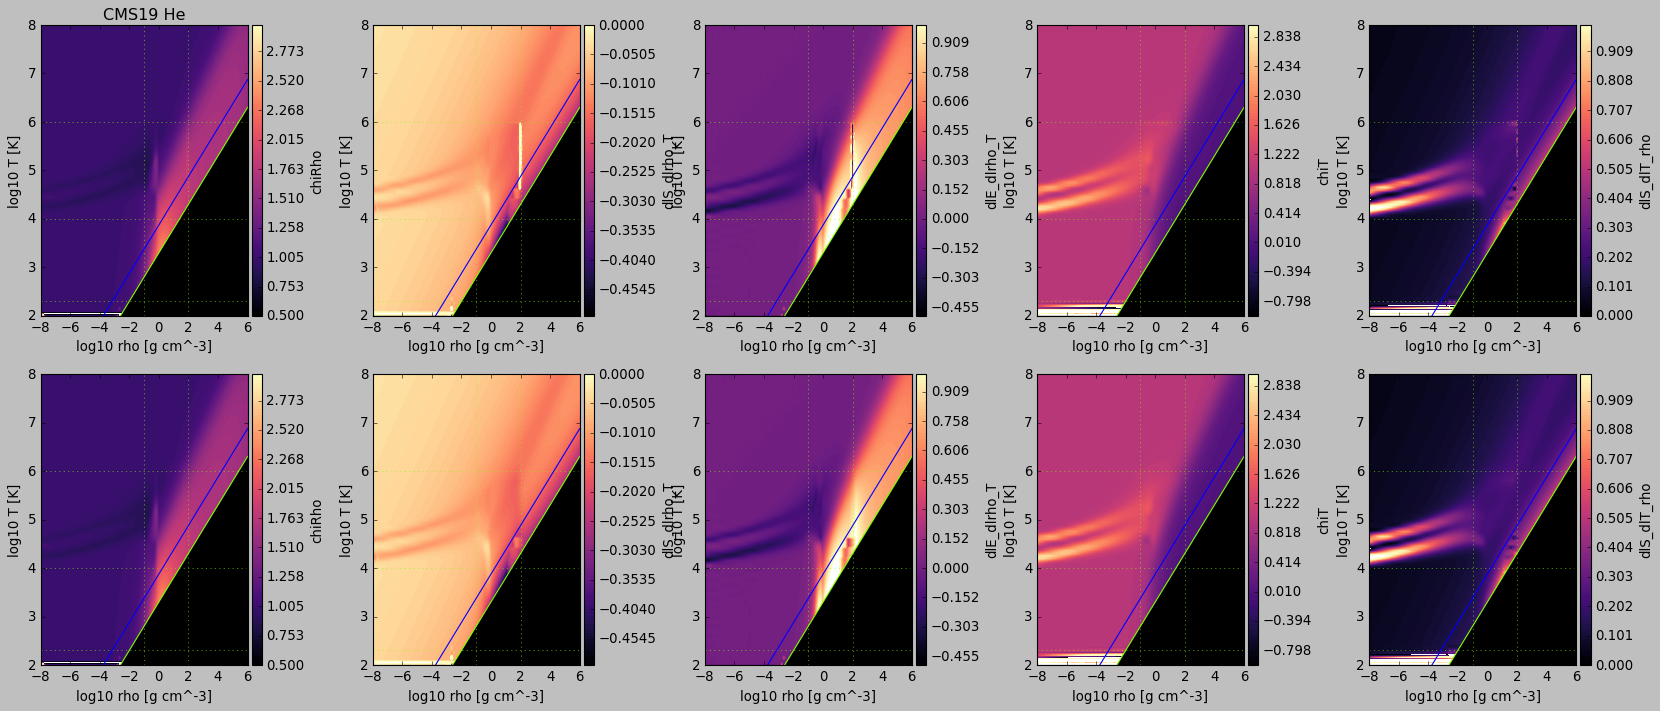

In [36]:
chiRho_vmin = 0.5
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -0.5
dlS_dlrho_T_vmax =0.#0.5
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -0.5
dlE_dlrho_T_vmax =1
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)


chiT_vmin = -1
chiT_vmax = 3
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = 0
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from cms_He table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')



# row 1: interpolated finite difference quantities from cms_He table, with linearly smoothed edges of the QMD region (particularly over the horizontal line log10T = 6 and the vertical line log10rho = 2)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')

for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(-1,color='#7FFF00',lw=0.5,ls=':')
    ax.axvline(2,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.3,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(6,color='#7FFF00',lw=0.5,ls=':')
    
    #to plot any contour log10Q = Q:
    # plot y = (x/2) + (12-Q)/2
    Qplot = 4.25
    ax.plot(np.linspace(-8,6,50), (1./2.)*np.linspace(-8,6,50) + (12-Qplot)/2, ls='-', color='b')

axes[0,0].set_title("CMS19 He")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [37]:
cms_He.chiRho = chiRho_smoothed
cms_He.dlS_dlrho_T = dlS_dlrho_T_smoothed
cms_He.dlE_dlrho_T = dlE_dlrho_T_smoothed
cms_He.chiT = chiT_smoothed
cms_He.dlS_dlT_rho = dlS_dlT_rho_smoothed

In [38]:
MESA_cols_6to16(cms_He,X=0,Y=1)

2.0
2.05
2.1
2.15
2.2
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05
4.1
4.15
4.2
4.25
4.3
4.35
4.4
4.45
4.5
4.55
4.6
4.65
4.7
4.75
4.8
4.85
4.9
4.95
5.0
5.05
5.1
5.15
5.2
5.25
5.3
5.35
5.4
5.45
5.5
5.55
5.6
5.65
5.7
5.75
5.8
5.85
5.9
5.95
6.0
6.05
6.1
6.15
6.2
6.25
6.3
6.35
6.4
6.45
6.5
6.55
6.6
6.65
6.7
6.75
6.8
6.85
6.9
6.95
7.0
7.05
7.1
7.15
7.2
7.25
7.3
7.35
7.4
7.45
7.5
7.55
7.6
7.65
7.7
7.75
7.8
7.85
7.9
7.95
8.0


In [39]:
write_MESA_table(cms_He, './my_MESAformat_tables/mesa-CMS_000x.data',version=1, X=0.0, Z=0.0)

# Mixture tables

In [40]:
# for mixed compositions: 
# interpolate to (P, T) (only need to do this for rho, S, E)
# then apply the linear mixing rule
# then re-interpolate to (rho, T) (see Aaron's code)

In [41]:
class interpolated_PTtable(object):
    '''
    For holding a (rho, T) table interpolated into (P, T) coordinates

    '''

    def __init__(self, rhoTtable, desired_Tarr=np.arange(2.,8.04,0.05), desired_Parr=np.arange(1.0,23.04,0.05), units='cgs', **kwargs):
        if units == 'cms' or units == 'cgs' or units == 'CMS':
            self.units = units
        else: 
            print('units must be cgs or mks or CMS (T [K], P [GPa], rho [g/cm^3], U [MJ/kg], S [MJ/kg/K])')

        self.X = rhoTtable.X
        self.Y = rhoTtable.Y

        self.atomic_number = rhoTtable.atomic_number
        self.mass_number = rhoTtable.mass_number

        start_Tgrid = rhoTtable.log10Tgrid
        start_rhogrid = rhoTtable.log10rhogrid
        start_Pgrid = rhoTtable.log10Pgrid
        start_Sgrid = rhoTtable.log10Sgrid
        start_Ugrid = rhoTtable.log10Ugrid

        self.log10rhogrid = None
        self.log10Sgrid = None
        self.log10Ugrid = None

        start_Tarr = np.arange(2.0, 8.04, 0.05)
        start_rhoarr = np.arange(-8.0,6.04, 0.05)

        allowedMask = ~meos.boundary_mask_rhoT(rhoTtable) & ~meos.boundary_mask_PT(rhoTtable) #& (rhoTtable.log10Tgrid >= 5.)
    
        masked_rho = np.ma.array(rhoTtable.log10rhogrid, mask=~allowedMask, fill_value = np.nan)
        masked_T = np.ma.array(rhoTtable.log10Tgrid, mask=~allowedMask, fill_value = np.nan)
        masked_S = np.ma.array(rhoTtable.log10Sgrid, mask=~allowedMask, fill_value = np.nan)
        masked_P = np.ma.array(rhoTtable.log10Pgrid, mask=~allowedMask, fill_value = np.nan)
        masked_U = np.ma.array(rhoTtable.log10Ugrid, mask=~allowedMask, fill_value = np.nan)
        

        #self.log10Tgrid, self.log10Pgrid = np.meshgrid(start_Tarr, desired_Parr)
        self.log10Tgrid, self.log10Pgrid = np.meshgrid(desired_Tarr, desired_Parr)



        # construct an interpolator to get P as a function of (rho, T)
        interp_log10P_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_P, bounds_error=False, fill_value=None, method='cubic')
        interp_log10P_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_P, bounds_error=False, fill_value=None, method='slinear')
        interp_log10P_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_P, bounds_error=False, fill_value=None, method='linear')

        #rbs_log10P = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, start_Pgrid)
        #rbs_log10S = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, start_Sgrid)
        #rbs_log10U = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, start_Ugrid)

        rbs_log10P = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, masked_P, kx=5,ky=5)
        rbs_log10S = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, masked_S, kx=5,ky=5)
        rbs_log10U = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, masked_U, kx=5,ky=5)

        def interp_log10P(log10rho, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10P_given_log10rho_log10T_cubic((log10rho,log10T))
                #return rbs_log10P(log10rho,log10T)
            elif method == 'slinear':
                return interp_log10P_given_log10rho_log10T_slinear((log10rho,log10T))
            elif method == 'linear':
                return interp_log10P_given_log10rho_log10T_linear((log10rho,log10T))
        
        def log10P_abs_diff(log10rho, log10P, log10T, method='cubic'):
            return np.abs(log10P - interp_log10P(log10rho,log10T,method))


        # construct interpolators to get S and U as functions of (rho,T)
        interp_log10S_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_S, bounds_error=False, fill_value=None, method='cubic')
        interp_log10S_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_S, bounds_error=False, fill_value=None, method='slinear')
        interp_log10S_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_S, bounds_error=False, fill_value=None, method='linear')
        
        interp_log10U_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_U, bounds_error=False, fill_value=None, method='cubic')
        interp_log10U_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_U, bounds_error=False, fill_value=None, method='slinear')
        interp_log10U_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_U, bounds_error=False, fill_value=None, method='linear')
        
        
        def interp_log10S(log10rho, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10S_given_log10rho_log10T_cubic((log10rho,log10T))
                #return rbs_log10S(log10rho,log10T)
            elif method == 'slinear':
                return interp_log10S_given_log10rho_log10T_slinear((log10rho,log10T))
            elif method == 'linear':
                return interp_log10S_given_log10rho_log10T_linear((log10rho,log10T))
        
        def interp_log10U(log10rho, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10U_given_log10rho_log10T_cubic((log10rho,log10T))
                #return rbs_log10U(log10rho,log10T)
            elif method == 'slinear':
                return interp_log10U_given_log10rho_log10T_slinear((log10rho,log10T))
            elif method == 'linear':
                return interp_log10U_given_log10rho_log10T_linear((log10rho,log10T))
        
        
        def solve_log10rhoSU(log10P, log10T, log10rho0=-5., method='cubic'):
            opt = optimize.minimize(log10P_abs_diff, x0=log10rho0, args=(log10P,log10T,method),bounds=[(-8.05,6.05)], tol=1.e-10) #lower and upper bounds on rho come from np.min, max of np.log10(maz_cepam_rhogrid)
            opt_log10rho = opt.x[0]
        
            corresponding_log10S = interp_log10S(opt_log10rho, log10T, method)
            corresponding_log10U = interp_log10U(opt_log10rho, log10T, method)
            return opt_log10rho, corresponding_log10S, corresponding_log10U
        


        # interpolate!
        log10rhogrid_interpolated = np.zeros_like(self.log10Tgrid)
        log10Sgrid_interpolated = np.zeros_like(self.log10Tgrid)
        log10Ugrid_interpolated = np.zeros_like(self.log10Tgrid)
        
        for i in range(np.shape(self.log10Tgrid)[1]):
            this_log10T = self.log10Tgrid[0][i]
            for j in range(np.shape(self.log10Pgrid)[0]):
                this_log10P = self.log10Pgrid[:,0][j]
        
                # try cubic interpolation first
                interpolated_log10rho, interpolated_log10S, interpolated_log10U  = solve_log10rhoSU(log10P=this_log10P, log10T=this_log10T, log10rho0=-5, method='slinear')
        
                log10rhogrid_interpolated[j,i] = interpolated_log10rho
                log10Sgrid_interpolated[j,i] = interpolated_log10S
                log10Ugrid_interpolated[j,i] = interpolated_log10U

        self.log10rhogrid = log10rhogrid_interpolated
        self.log10Sgrid = log10Sgrid_interpolated
        self.log10Ugrid = log10Ugrid_interpolated

        
       

In [42]:
class simple_table(object):
    def __init__(self, units='cgs', **kwargs):
        if units == 'cms' or units == 'cgs' or units == 'CMS':
            self.units = units
        else: 
            print('units must be cgs or mks or CMS (T [K], P [GPa], rho [g/cm^3], U [MJ/kg], S [MJ/kg/K])')

        self.X = None
        self.Y = None
        
        self.atomic_number = None
        self.mass_number = None

        self.log10Tgrid = None
        self.log10Pgrid = None
        self.log10rhogrid = None
        self.log10Sgrid = None
        self.log10Ugrid = None

In [43]:
def add_mixing_terms(H_PTtable, He_PTtable, Z_PTtable=None, X=0.755, Y=0.245, HG23path="/Users/emily/Documents/astro/giant_planets/MESA_EoS/HG23_Vmix_Smix_Umix.csv"):
    """
    Assumes that all three input tables are evaluated on the same P, T grid, and that
    the grid coordinates are
    
    Tarr=np.arange(2.,8.04,0.05) 
    Parr=np.arange(1.0,23.04,0.05)

    Mixing terms are given by Howard & Guillot 2023 eqs 1,2
    
    1/rho_mix = X/rho_H + Y/rho_He + X*Y*V_mix, where V_mix is given in the table
    S_mix = X*S_H + Y*S_He + X*Y*S_mix
    E_mix = X*E_H + Y*E_He
    """

    Z = 1. - (X + Y)

    shared_log10Tgrid = H_PTtable.log10Tgrid
    shared_log10Pgrid = H_PTtable.log10Pgrid

    mixed_table = simple_table()
    mixed_table.X = X
    mixed_table.Y = Y
    mixed_table.log10Tgrid = shared_log10Tgrid
    mixed_table.log10Pgrid = shared_log10Pgrid

    mixed_log10rhogrid = np.zeros_like(shared_log10Tgrid)
    mixed_log10Sgrid = np.zeros_like(shared_log10Tgrid)
    mixed_log10Ugrid = np.zeros_like(shared_log10Tgrid)

    HG23 = np.genfromtxt(HG23path,delimiter=',')

    Tarr = np.arange(2.,8.04,0.05)
    Parr = np.arange(1.0,23.04,0.05)

    for i, P in enumerate(Parr):
        Pround = np.round(P,2)
        this_Pmask_HG23 = (np.round(HG23[:,0],2) == Pround)

        for j, T in enumerate(Tarr):
            Tround = np.round(T,2)

            this_Vmix = HG23[this_Pmask_HG23][:,2][j]
            this_Smix = HG23[this_Pmask_HG23][:,3][j]
            this_Umix = HG23[this_Pmask_HG23][:,4][j]

            rho_H = 10**H_PTtable.log10rhogrid[i,j]
            rho_He = 10**He_PTtable.log10rhogrid[i,j]

            S_H = 10**H_PTtable.log10Sgrid[i,j]
            S_He = 10**He_PTtable.log10Sgrid[i,j]

            U_H = 10**H_PTtable.log10Ugrid[i,j]
            U_He = 10**He_PTtable.log10Ugrid[i,j]

            if Z_PTtable is None:
                mixed_log10rhogrid[i,j] = np.log10(1./((X/rho_H) + (Y/rho_He) + X*Y*this_Vmix))
                mixed_log10Sgrid[i,j] = np.log10(X*S_H + Y*S_He + X*Y*this_Smix)
                mixed_log10Ugrid[i,j] = np.log10(X*U_H + Y*U_He + X*Y*this_Umix)
                '''
                if ~np.isfinite(mixed_log10Sgrid[i,j]):
                    print(X*S_H + Y*S_He + X*Y*this_Smix)
                    #print("H contribution is")
                    #print(S_H)
                    #print("He contribution is")
                    #print(S_He)
                    #print("S_mix is")
                    #print(this_Smix)
                    print(mixed_log10Sgrid[i,j])
                    print(mixed_log10rhogrid[i,j])
                    print(mixed_log10Ugrid[i,j])
                    print("P,T is")
                    print(P,T)
                '''

            else:
                rho_Z = 10**Z_PTtable.log10rhogrid[i,j]
                S_Z = 10**Z_PTtable.log10Sgrid[i,j]
                U_Z = 10**Z_PTtable.log10Ugrid[i,j]
                
                mixed_log10rhogrid[i,j] = np.log10(1./((X/rho_H) + (Y/rho_He) + (Z/rho_Z) + X*Y*this_Vmix))
                mixed_log10Sgrid[i,j] = np.log10(X*S_H + Y*S_He + X*Y*this_Smix + Z*S_Z)
                mixed_log10Ugrid[i,j] = np.log10(X*U_H + Y*U_He + X*Y*this_Umix + Z*U_Z)
    
    mixed_table.log10rhogrid = mixed_log10rhogrid
    mixed_table.log10Sgrid = mixed_log10Sgrid
    mixed_table.log10Ugrid = mixed_log10Ugrid
    
    return mixed_table
    


In [44]:
class reinterpolate_mixed_table_to_rhoT(object):
    '''
    For holding the re-interpolation of a (P,T) table into (rho,T) coordinates

    '''

    def __init__(self, PTtable, X, Y, desired_Tarr=np.arange(2.,8.04,0.05), desired_rhoarr=np.arange(-8.0,6.04, 0.05), reference_Pgrid=None, units='cgs', **kwargs):
        if units == 'cms' or units == 'cgs' or units == 'CMS':
            self.units = units
        else: 
            print('units must be cgs or mks or CMS (T [K], P [GPa], rho [g/cm^3], U [MJ/kg], S [MJ/kg/K])')


        self.X = X
        self.Y = Y

        start_Tgrid = PTtable.log10Tgrid
        start_Pgrid = PTtable.log10Pgrid
        start_rhogrid = PTtable.log10rhogrid
        start_Sgrid = PTtable.log10Sgrid
        start_Ugrid = PTtable.log10Ugrid

        
        start_Tarr = np.arange(2.0, 8.04, 0.05)
        start_Parr = np.arange(1.0,23.04,0.05)

        # re-interpolate to (rho, T) for plot comparison
        self.log10Tgrid, self.log10rhogrid = np.meshgrid(desired_Tarr, desired_rhoarr)
        self.log10Pgrid = None
        self.log10Sgrid = None
        self.log10Ugrid = None

        # construct an interpolator to get rho as a function of (P, T)
        interp_log10rho_given_log10P_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_rhogrid, bounds_error=False, fill_value=None, method='cubic')
        interp_log10rho_given_log10P_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_rhogrid, bounds_error=False, fill_value=None, method='slinear')
        interp_log10rho_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_rhogrid, bounds_error=False, fill_value=None, method='linear')

        def interp_log10rho(log10P, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10rho_given_log10P_log10T_cubic((log10P,log10T))
            elif method == 'slinear':
                return interp_log10rho_given_log10P_log10T_slinear((log10P,log10T))
            elif method == 'linear':
                return interp_log10rho_given_log10P_log10T_linear((log10P,log10T))
        
        def log10rho_abs_diff(log10P, log10rho, log10T, method='cubic'):
            return np.abs(log10rho - interp_log10rho(log10P,log10T,method))


        # construct interpolators to get S and U as functions of (P,T)
        interp_log10S_given_log10P_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Sgrid, bounds_error=False, fill_value=None, method='cubic')
        interp_log10S_given_log10P_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Sgrid, bounds_error=False, fill_value=None, method='slinear')
        interp_log10S_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Sgrid, bounds_error=False, fill_value=None, method='linear')
        
        interp_log10U_given_log10P_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Ugrid, bounds_error=False, fill_value=None, method='cubic')
        interp_log10U_given_log10P_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Ugrid, bounds_error=False, fill_value=None, method='slinear')
        interp_log10U_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Ugrid, bounds_error=False, fill_value=None, method='linear')

        def reinterp_log10S(log10P, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10S_given_log10P_log10T_cubic((log10P,log10T))
            elif method == 'slinear':
                return interp_log10S_given_log10P_log10T_slinear((log10P,log10T))
            elif method == 'linear':
                return interp_log10S_given_log10P_log10T_linear((log10P,log10T))
        
        def reinterp_log10U(log10P, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10U_given_log10P_log10T_cubic((log10P,log10T))
            elif method == 'slinear':
                return interp_log10U_given_log10P_log10T_slinear((log10P,log10T))
            elif method == 'linear':
                return interp_log10U_given_log10P_log10T_linear((log10P,log10T))
        
        
        def solve_log10PSU(log10rho, log10T, log10P0=5., method='linear'):
            opt = optimize.minimize(log10rho_abs_diff, x0=log10P0, args=(log10rho,log10T,method),bounds=[(1.0,24.0)], tol=1.e-10) 
            opt_log10P = opt.x[0]
        
            recorresponding_log10S = reinterp_log10S(opt_log10P, log10T, method)
            recorresponding_log10U = reinterp_log10U(opt_log10P, log10T, method)
            return opt_log10P, recorresponding_log10S, recorresponding_log10U


        # interpolate!
        log10Pgrid_reinterpolated = np.zeros_like(self.log10Tgrid)
        log10Sgrid_reinterpolated = np.zeros_like(self.log10Tgrid)
        log10Ugrid_reinterpolated = np.zeros_like(self.log10Tgrid)
        
        for i in range(np.shape(self.log10Tgrid)[1]):
            this_log10T = self.log10Tgrid[0][i]
            for j in range(np.shape(self.log10rhogrid)[0]):
                this_log10rho = self.log10rhogrid[:,0][j]

                if reference_Pgrid is not None:
                     reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=reference_Pgrid[j,i], method='slinear')
                else:
                    if this_log10T < 4.5:
                        if this_log10rho < -6.5:
                            reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=4.5, method='slinear')
                        else:
                            reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=5, method='slinear')
                    else:
                        if this_log10rho < -5.5:
                            reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=8, method='slinear')
                        else:
                            reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=10, method='slinear')
            
                log10Pgrid_reinterpolated[j,i] = reinterpolated_log10P
                log10Sgrid_reinterpolated[j,i] = reinterpolated_log10S
                log10Ugrid_reinterpolated[j,i] = reinterpolated_log10U

        self.log10Pgrid = log10Pgrid_reinterpolated
        self.log10Sgrid = log10Sgrid_reinterpolated
        self.log10Ugrid = log10Ugrid_reinterpolated
        
        self.chiRho = None # finite diff quantity 1, aka dlP_dlrho_T
        self.dlS_dlrho_T = None # finite diff quantity 3
        self.dlE_dlrho_T = None

        self.chiT = None # finite diff quantity 2, aka dlP_dlT_rho
        self.dlS_dlT_rho = None # finite diff quantity 4

        self.Cp = None
        self.Cv = None

        self.dE_drho_T = None
        self.dS_dT_rho = None
        self.dS_drho_T = None
        self.dE_drho_T_direct = None
        self.dS_dT_rho_direct = None
        self.dS_drho_T_direct = None
        self.mu = None
        self.log_free_e = None
        self.gamma1 = None
        self.gamma3 = None
        self.grad_ad = None
        self.eta = None
        self.log10Qgrid = self.log10rhogrid - 2.*self.log10Tgrid + 12

# Check that interpolation to (P,T) and reinterpolation to (rho,T) don't affect H and He grids

## pure H

In [45]:
start = time.time()
bln_H_PT = interpolated_PTtable(bln_H)
end = time.time()
print((end-start)/60.)

4.580037152767181


In [46]:
start = time.time()
bln_H_rhoT_reinterp = reinterpolate_mixed_table_to_rhoT(bln_H_PT,reference_Pgrid=bln_H.log10Pgrid,X=1,Y=0)
end = time.time()
print((end-start)/60.)

2.0536052028338116


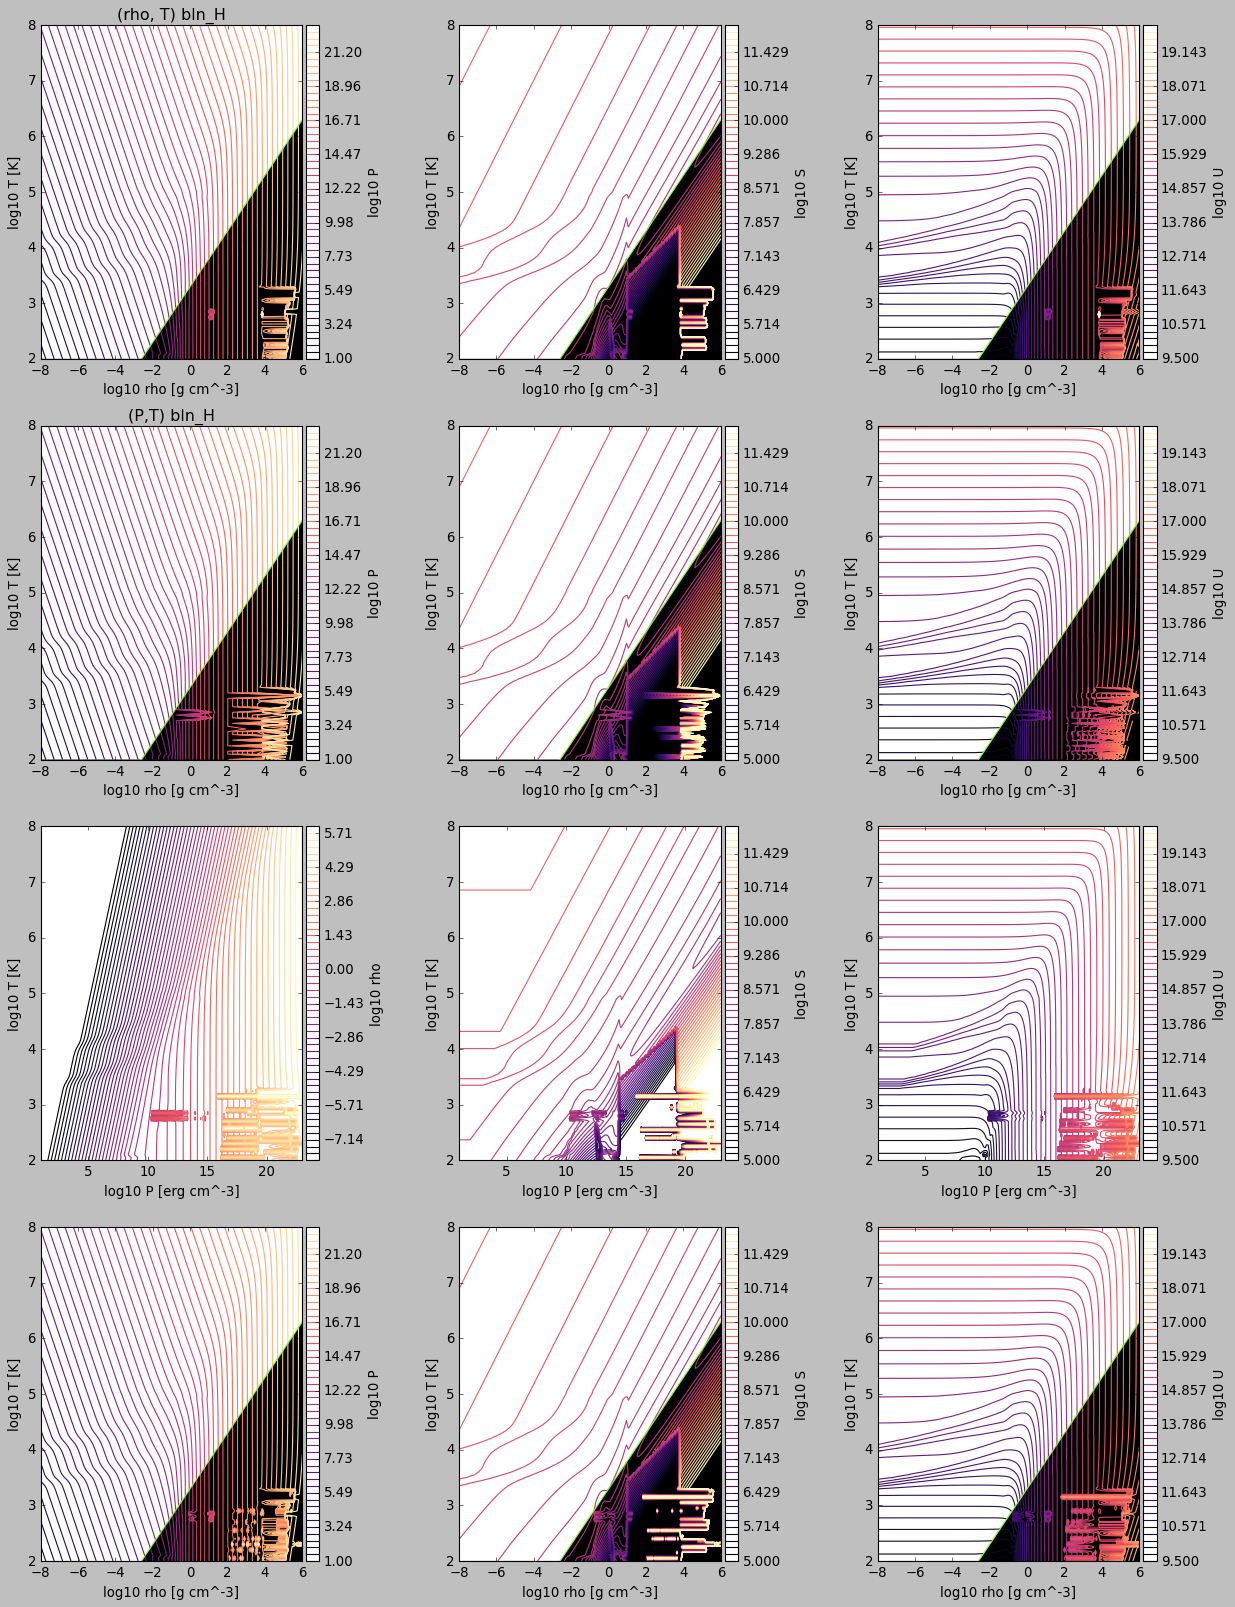

In [47]:
log10Plevels = np.linspace(1,23,50)
log10Pvmin = 0.
log10Pvmax = 24

log10Slevels = np.linspace(5,12,50)
log10Svmin = 5
log10Svmax = 12

log10Ulevels = np.linspace(9.5,20,50)
log10Uvmin = 9.5
log10Uvmax = 20

log10rholevels = np.linspace(-8,6,50)
log10rhovmin = -8.
log10rhovmax = 6


fig, axes = plt.subplots(4,3,figsize=(18,24))

# row 0: original (rho, T) version of bln_H table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: re-based to (P,T)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')

# row 2: re-based to (P,T), plotted in (P,T) space
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contour(bln_H_PT.log10Pgrid, bln_H_PT.log10Tgrid, bln_H_PT.log10rhogrid, levels=log10rholevels, cmap='magma',alpha=1,vmin=log10rhovmin, vmax=log10rhovmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10 rho')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contour(bln_H_PT.log10Pgrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10 S')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contour(bln_H_PT.log10Pgrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10 U')


# row 3: re-based again to (rho,t)
divider30 = make_axes_locatable(axes[3,0])
cax30 = divider30.append_axes('right', size='5%', pad=0.05)
cs30 = axes[3,0].contour(bln_H_rhoT_reinterp.log10rhogrid, bln_H_rhoT_reinterp.log10Tgrid, bln_H_rhoT_reinterp.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs30, cax=cax30, orientation='vertical',label='log10 P')

divider31 = make_axes_locatable(axes[3,1])
cax31 = divider31.append_axes('right', size='5%', pad=0.05)
cs31 = axes[3,1].contour(bln_H_rhoT_reinterp.log10rhogrid, bln_H_rhoT_reinterp.log10Tgrid, bln_H_rhoT_reinterp.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs31, cax=cax31, orientation='vertical',label='log10 S')

divider32 = make_axes_locatable(axes[3,2])
cax32 = divider32.append_axes('right', size='5%', pad=0.05)
cs32 = axes[3,2].contour(bln_H_rhoT_reinterp.log10rhogrid, bln_H_rhoT_reinterp.log10Tgrid, bln_H_rhoT_reinterp.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs32, cax=cax32, orientation='vertical',label='log10 U')


for ax in np.ravel(axes[0:2]):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')

for ax in axes[2]:
    ax.set_xlim(1.,23.)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 P [erg cm^-3]')
    ax.set_ylabel('log10 T [K]')

for ax in axes[3]:
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    #ax.axvline(-5.5,color='r')
    #ax.axvline(-6.5,color='r')

    
axes[0,0].set_title("(rho, T) bln_H")
axes[1,0].set_title("(P,T) bln_H")

plt.subplots_adjust(wspace=0.5)
plt.show()


# pure He

In [48]:
start = time.time()
cms_He_PT = interpolated_PTtable(cms_He)
end = time.time()
print((end-start)/60.)

4.460731267929077


In [49]:
start = time.time()
cms_He_rhoT_reinterp = reinterpolate_mixed_table_to_rhoT(cms_He_PT,reference_Pgrid=cms_He.log10Pgrid,X=0,Y=1)
end = time.time()
print((end-start)/60.)

1.9836619655291239


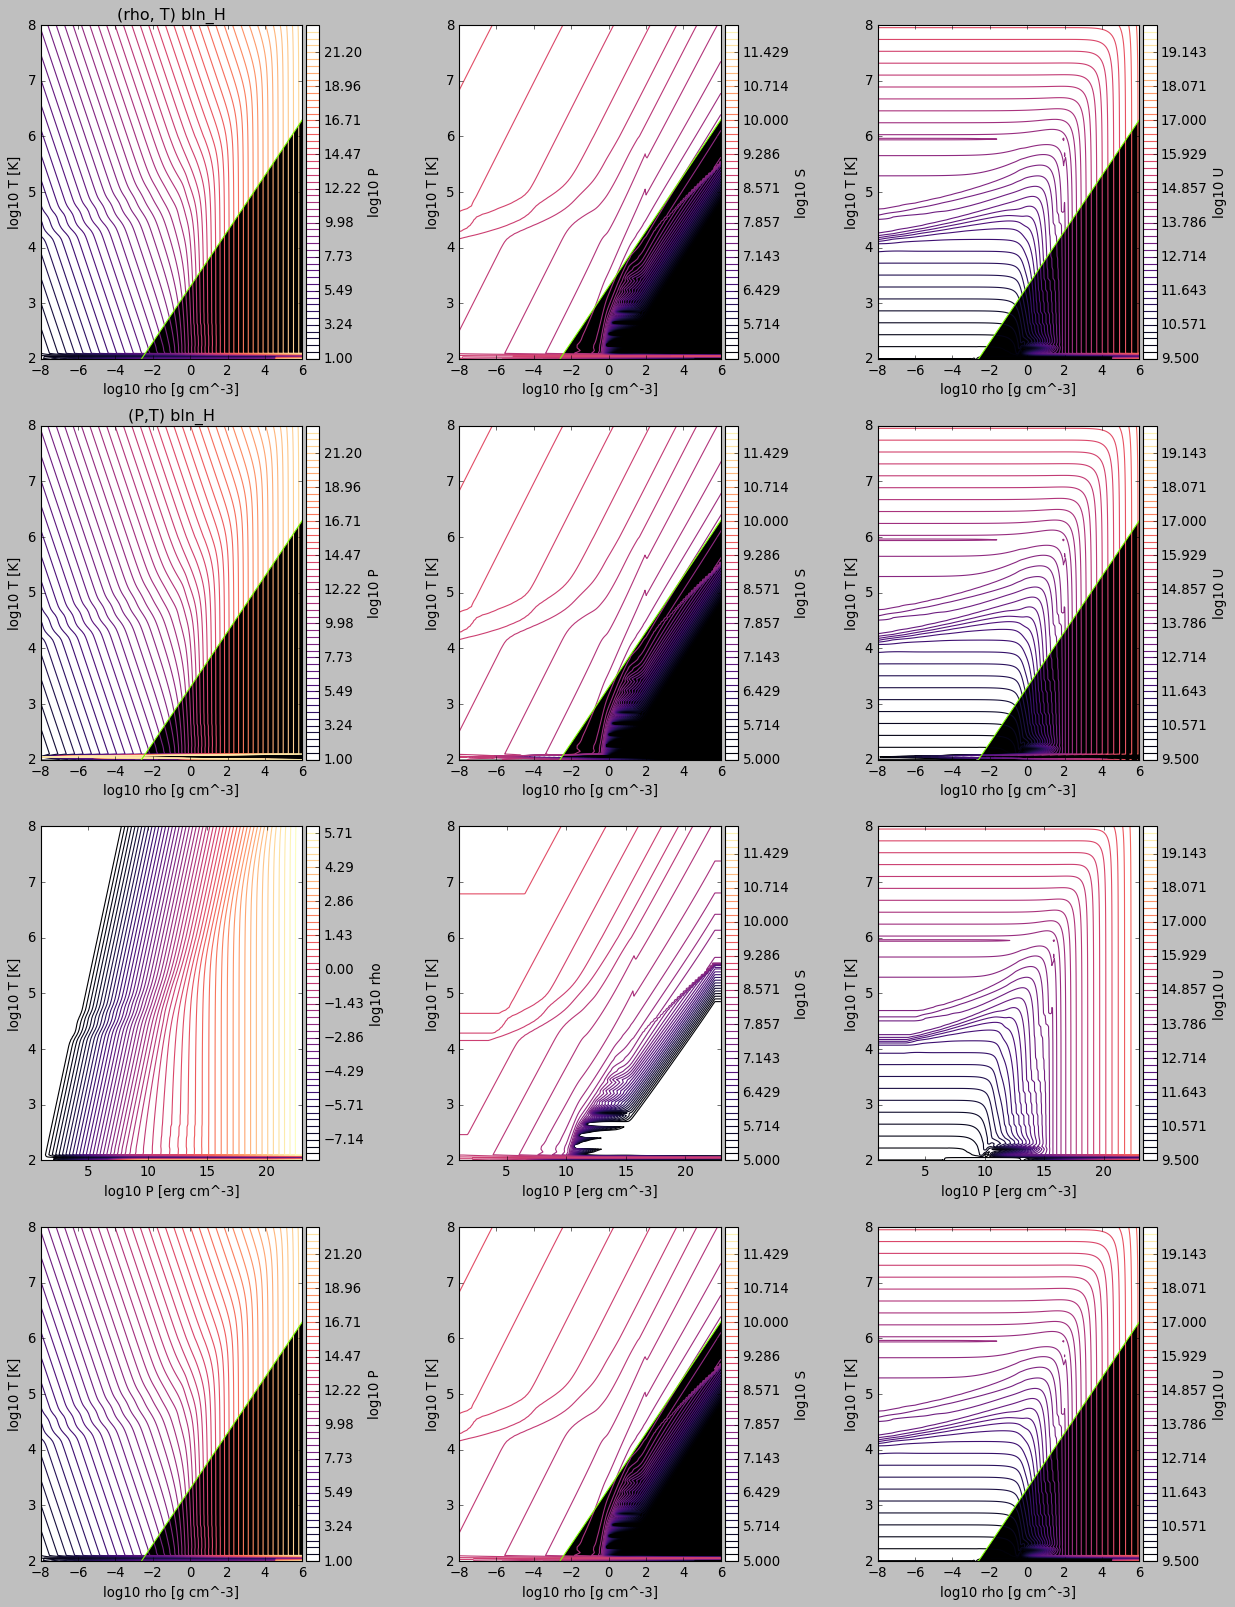

In [50]:
log10Plevels = np.linspace(1,23,50)
log10Pvmin = 0.
log10Pvmax = 24

log10Slevels = np.linspace(5,12,50)
log10Svmin = 5
log10Svmax = 12

log10Ulevels = np.linspace(9.5,20,50)
log10Uvmin = 9.5
log10Uvmax = 20

log10rholevels = np.linspace(-8,6,50)
log10rhovmin = -8.
log10rhovmax = 6


fig, axes = plt.subplots(4,3,figsize=(18,24))

# row 0: original (rho, T) version of bln_H table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: re-based to (P,T)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')

# row 2: re-based to (P,T), plotted in (P,T) space
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contour(cms_He_PT.log10Pgrid, cms_He_PT.log10Tgrid, cms_He_PT.log10rhogrid, levels=log10rholevels, cmap='magma',alpha=1,vmin=log10rhovmin, vmax=log10rhovmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10 rho')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contour(cms_He_PT.log10Pgrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10 S')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contour(cms_He_PT.log10Pgrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10 U')


# row 3: re-based again to (rho,t)
divider30 = make_axes_locatable(axes[3,0])
cax30 = divider30.append_axes('right', size='5%', pad=0.05)
cs30 = axes[3,0].contour(cms_He_rhoT_reinterp.log10rhogrid, cms_He_rhoT_reinterp.log10Tgrid, cms_He_rhoT_reinterp.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs30, cax=cax30, orientation='vertical',label='log10 P')

divider31 = make_axes_locatable(axes[3,1])
cax31 = divider31.append_axes('right', size='5%', pad=0.05)
cs31 = axes[3,1].contour(cms_He_rhoT_reinterp.log10rhogrid, cms_He_rhoT_reinterp.log10Tgrid, cms_He_rhoT_reinterp.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs31, cax=cax31, orientation='vertical',label='log10 S')

divider32 = make_axes_locatable(axes[3,2])
cax32 = divider32.append_axes('right', size='5%', pad=0.05)
cs32 = axes[3,2].contour(cms_He_rhoT_reinterp.log10rhogrid, cms_He_rhoT_reinterp.log10Tgrid, cms_He_rhoT_reinterp.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs32, cax=cax32, orientation='vertical',label='log10 U')


for ax in np.ravel(axes[0:2]):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')

for ax in axes[2]:
    ax.set_xlim(1.,23.)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 P [erg cm^-3]')
    ax.set_ylabel('log10 T [K]')

for ax in axes[3]:
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    #ax.axvline(-5.5,color='r')
    #ax.axvline(-6.5,color='r')

    
axes[0,0].set_title("(rho, T) bln_H")
axes[1,0].set_title("(P,T) bln_H")

plt.subplots_adjust(wspace=0.5)
plt.show()


# mixed tables

-270.36971444541535
7.038508489967395
-10238151801.193224
77341822204727.23
-22040763200934.375
8086301753918.012


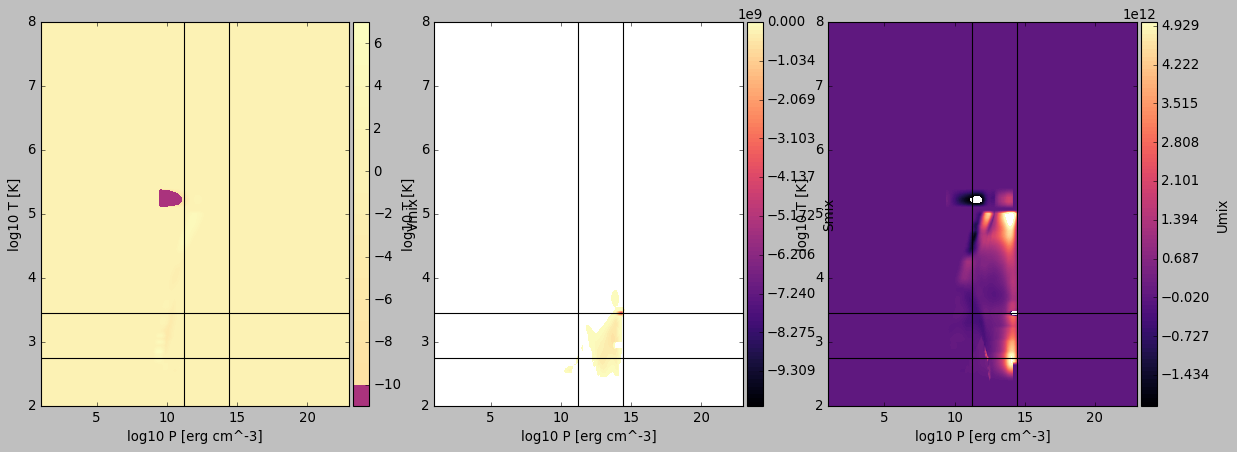

In [51]:
# plot Vmix, Smix across the P,T grid
HG23 = np.genfromtxt("/Users/emily/Documents/astro/giant_planets/MESA_EoS/HG23_Vmix_Smix_Umix.csv",delimiter=',')

Tarr = np.arange(2.,8.04,0.05)
Parr = np.arange(1.0,23.04,0.05)

HG23_log10Tgrid, HG23_log10Pgrid = np.meshgrid(Tarr, Parr)
HG23_Vmixgrid = np.zeros_like(HG23_log10Tgrid)
HG23_Smixgrid = np.zeros_like(HG23_log10Tgrid)
HG23_Umixgrid = np.zeros_like(HG23_log10Tgrid)

for j in range(441):
    HG23_Vmixgrid[j] = HG23[:,2][121*j : 121*(j+1)]
    HG23_Smixgrid[j] = HG23[:,3][121*j : 121*(j+1)]
    HG23_Umixgrid[j] = HG23[:,4][121*j : 121*(j+1)]
    
print(np.min(HG23_Vmixgrid))
print(np.max(HG23_Vmixgrid))

print(np.min(HG23_Smixgrid))
print(np.max(HG23_Smixgrid))

print(np.min(HG23_Umixgrid))
print(np.max(HG23_Umixgrid))


Vmix_vmin = -270
Vmix_vmax = 7
Vmin_levels = np.array((-270.,-10.,-9,-8,-7,-6,-5.,-4,-3,-2,-1.,0.,1,2,3,4,5.,6,7))

Smix_vmin = -1.024e10
Smix_vmax = 0#1.e10#7.74e13
Smin_levels = np.linspace(Smix_vmin, Smix_vmax, 100)

Umix_vmin = -2.e12    #-1.024e10
Umix_vmax = 5.e12 #7.74e13
Umin_levels = np.linspace(Umix_vmin, Umix_vmax, 100)

fig, axes = plt.subplots(1,3,figsize=(18,6))

# row 0: original (rho, T) version of bln_H table
divider00 = make_axes_locatable(axes[0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0].contourf(HG23_log10Pgrid, HG23_log10Tgrid, HG23_Vmixgrid, levels=Vmin_levels, cmap='magma',alpha=1,vmin=Vmix_vmin, vmax=Vmix_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='Vmix')

divider01 = make_axes_locatable(axes[1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[1].contourf(HG23_log10Pgrid, HG23_log10Tgrid, HG23_Smixgrid, levels=Smin_levels, cmap='magma',alpha=1,vmin=Smix_vmin, vmax=Smix_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='Smix')

divider02 = make_axes_locatable(axes[2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[2].contourf(HG23_log10Pgrid, HG23_log10Tgrid, HG23_Umixgrid, levels=Umin_levels, cmap='magma',alpha=1,vmin=Umix_vmin, vmax=Umix_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='Umix')


for ax in axes:
    ax.set_xlim(1.,23.)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 P [erg cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.axhline(2.75,color='k')
    ax.axhline(3.45,color='k')
    ax.axvline(11.25,color='k')
    ax.axvline(14.45,color='k')

plt.show()


In [52]:
mixed_H_He = add_mixing_terms(H_PTtable=bln_H_PT, He_PTtable=cms_He_PT, Z_PTtable=None, X=0.1, Y=0.9, HG23path="/Users/emily/Documents/astro/giant_planets/MESA_EoS/HG23_Vmix_Smix_Umix.csv")
mixed_H_He.log10Sgrid[~np.isfinite(mixed_H_He.log10Sgrid)] = 0.

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/738257404.py:58: RuntimeWarning: invalid value encountered in log10
  mixed_log10Sgrid[i,j] = np.log10(X*S_H + Y*S_He + X*Y*this_Smix)


In [53]:
start = time.time()
mixed_H_He_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=cms_He.log10Pgrid, X=0.1, Y=0.9)
end = time.time()
print((end-start)/60.)

3.041349883874257


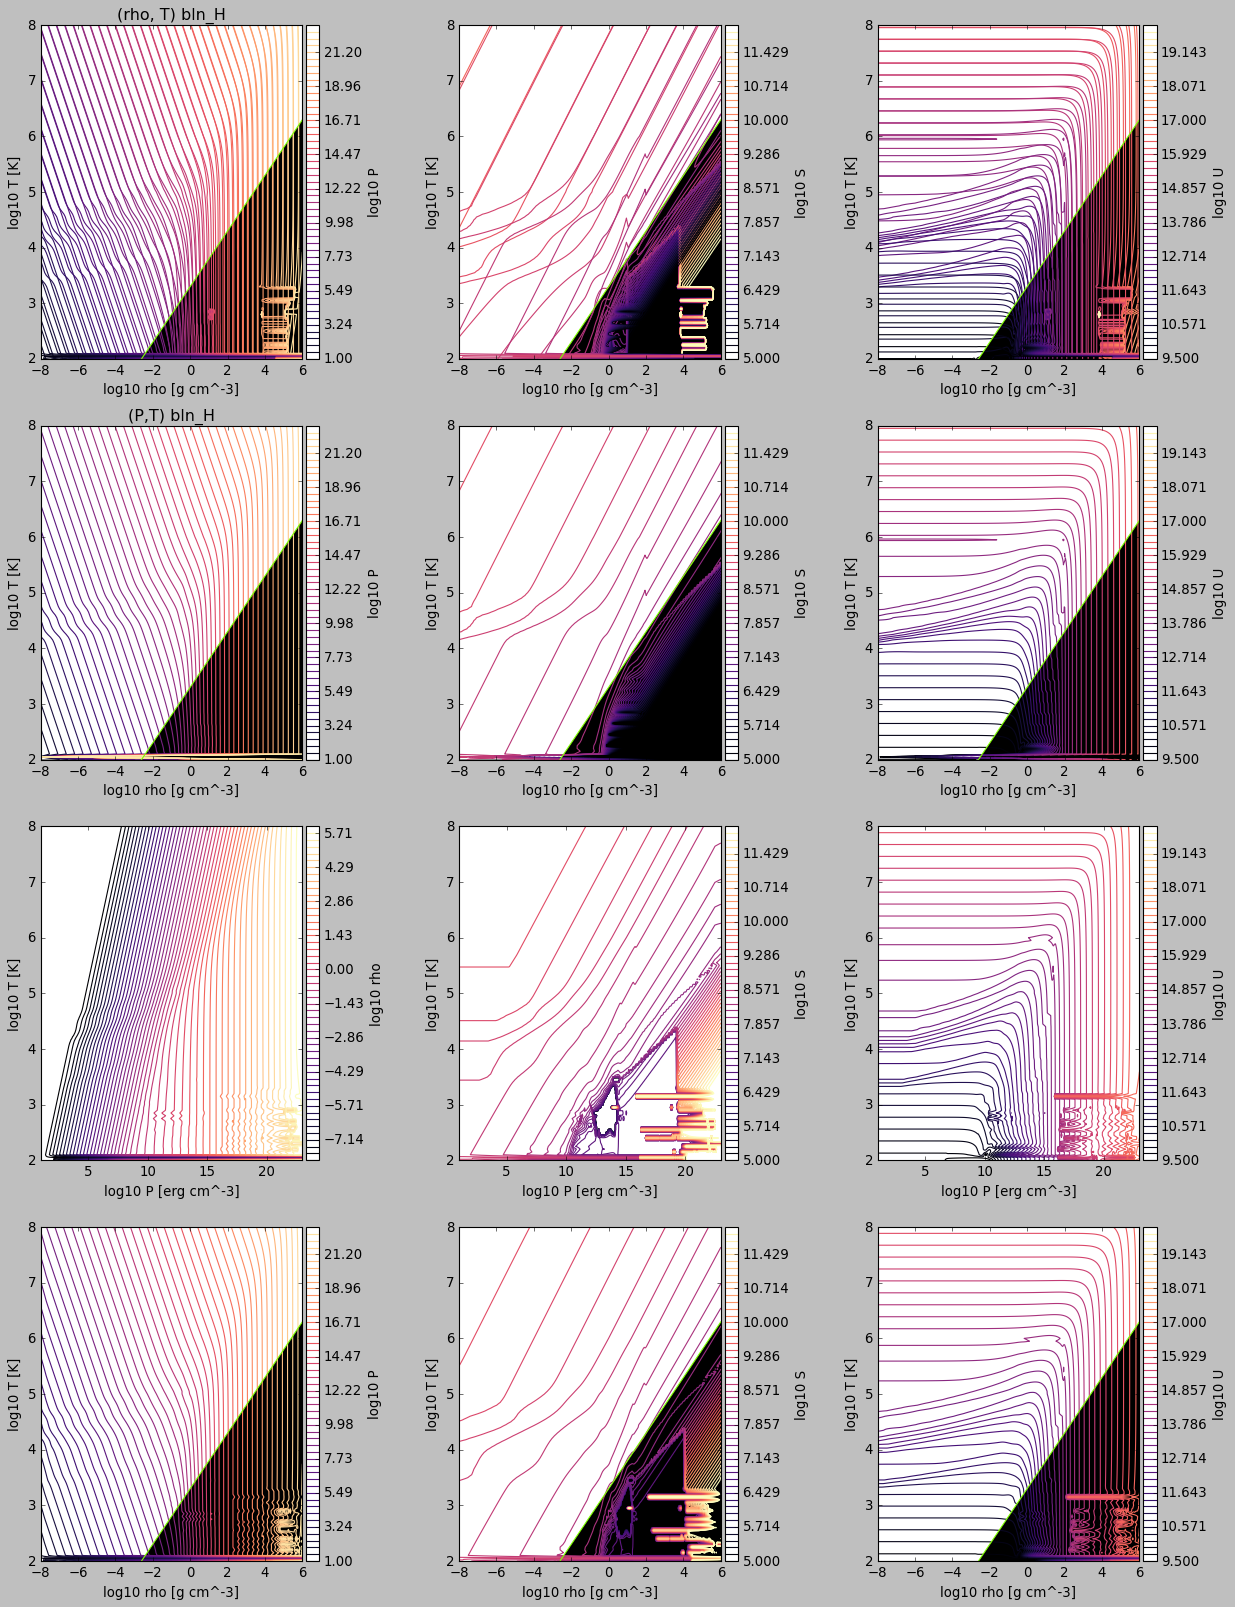

In [54]:
log10Plevels = np.linspace(1,23,50)
log10Pvmin = 0.
log10Pvmax = 24

log10Slevels = np.linspace(5,12,50)
log10Svmin = 5
log10Svmax = 12

log10Ulevels = np.linspace(9.5,20,50)
log10Uvmin = 9.5
log10Uvmax = 20

log10rholevels = np.linspace(-8,6,50)
log10rhovmin = -8.
log10rhovmax = 6


fig, axes = plt.subplots(4,3,figsize=(18,24))

# row 0: original (rho, T) version of bln_H table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
cs00 = axes[0,0].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
cs01 = axes[0,1].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
cs02 = axes[0,2].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: re-based to (P,T)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
#cs10 = axes[1,0].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
cs10 = axes[1,0].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
#cs11 = axes[1,1].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
cs11 = axes[1,1].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
#cs12 = axes[1,2].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
cs12 = axes[1,2].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')

# row 2: re-based to (P,T), plotted in (P,T) space
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contour(mixed_H_He.log10Pgrid, mixed_H_He.log10Tgrid, mixed_H_He.log10rhogrid, levels=log10rholevels, cmap='magma',alpha=1,vmin=log10rhovmin, vmax=log10rhovmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10 rho')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contour(mixed_H_He.log10Pgrid, mixed_H_He.log10Tgrid, mixed_H_He.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10 S')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contour(mixed_H_He.log10Pgrid, mixed_H_He.log10Tgrid, mixed_H_He.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10 U')


# row 3: re-based again to (rho,t)
divider30 = make_axes_locatable(axes[3,0])
cax30 = divider30.append_axes('right', size='5%', pad=0.05)
cs30 = axes[3,0].contour(mixed_H_He_rhoT.log10rhogrid, mixed_H_He_rhoT.log10Tgrid, mixed_H_He_rhoT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs30, cax=cax30, orientation='vertical',label='log10 P')

divider31 = make_axes_locatable(axes[3,1])
cax31 = divider31.append_axes('right', size='5%', pad=0.05)
cs31 = axes[3,1].contour(mixed_H_He_rhoT.log10rhogrid, mixed_H_He_rhoT.log10Tgrid, mixed_H_He_rhoT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs31, cax=cax31, orientation='vertical',label='log10 S')

divider32 = make_axes_locatable(axes[3,2])
cax32 = divider32.append_axes('right', size='5%', pad=0.05)
cs32 = axes[3,2].contour(mixed_H_He_rhoT.log10rhogrid, mixed_H_He_rhoT.log10Tgrid, mixed_H_He_rhoT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs32, cax=cax32, orientation='vertical',label='log10 U')


for ax in np.ravel(axes[0:2]):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')

for ax in axes[2]:
    ax.set_xlim(1.,23.)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 P [erg cm^-3]')
    ax.set_ylabel('log10 T [K]')

for ax in axes[3]:
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    #ax.axvline(-5.5,color='r')
    #ax.axvline(-6.5,color='r')

    
axes[0,0].set_title("(rho, T) bln_H")
axes[1,0].set_title("(P,T) bln_H")

plt.subplots_adjust(wspace=0.5)
plt.show()


# okay, that looks good! time to make and write a range of tables covering X mass fractions between 100 and 0.

In [ ]:
Xarr = np.arange(0.1,1.0,0.1)
print(Xarr)
Yarr = 1.-Xarr
print(Yarr)

for i, xi in enumerate(Xarr):
    
    mixed_H_He = add_mixing_terms(H_PTtable=bln_H_PT, He_PTtable=cms_He_PT, Z_PTtable=None, X=Xarr[i], Y=1.-Xarr[i], HG23path="/Users/emily/Documents/astro/giant_planets/MESA_EoS/HG23_Vmix_Smix_Umix.csv")
    mixed_H_He.log10Sgrid[~np.isfinite(mixed_H_He.log10Sgrid)] = 0.

    
    start = time.time()
    if xi > 0.5:
        mixed_H_He_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=bln_H.log10Pgrid, X=Xarr[i], Y=1.-Xarr[i])
    else:
        mixed_H_He_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=cms_He.log10Pgrid, X=Xarr[i], Y=1.-Xarr[i])
    end = time.time()
    print((end-start)/60.)

    mixed_H_He_rhoT.chiRho, mixed_H_He_rhoT.dlS_dlrho_T, mixed_H_He_rhoT.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(mixed_H_He_rhoT)
    mixed_H_He_rhoT.chiT, mixed_H_He_rhoT.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(mixed_H_He_rhoT)

    MESA_cols_6to16(mixed_H_He_rhoT, X=Xarr[i],Y=1.-Xarr[i])
    write_MESA_table(mixed_H_He_rhoT, './my_MESAformat_tables/mesa-CMS_0{0}0x.data'.format(str(np.round(xi,1))[-1]),version=1, X=xi, Z=0.0)
    

# pure H2O table

In [65]:

infile = open('./my_Ztables/blended_h2o.pkl','rb')
h2o = pickle.load(infile)
infile.close()

h2o.chiRho, h2o.dlS_dlrho_T, h2o.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(h2o)
h2o.chiT, h2o.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(h2o)


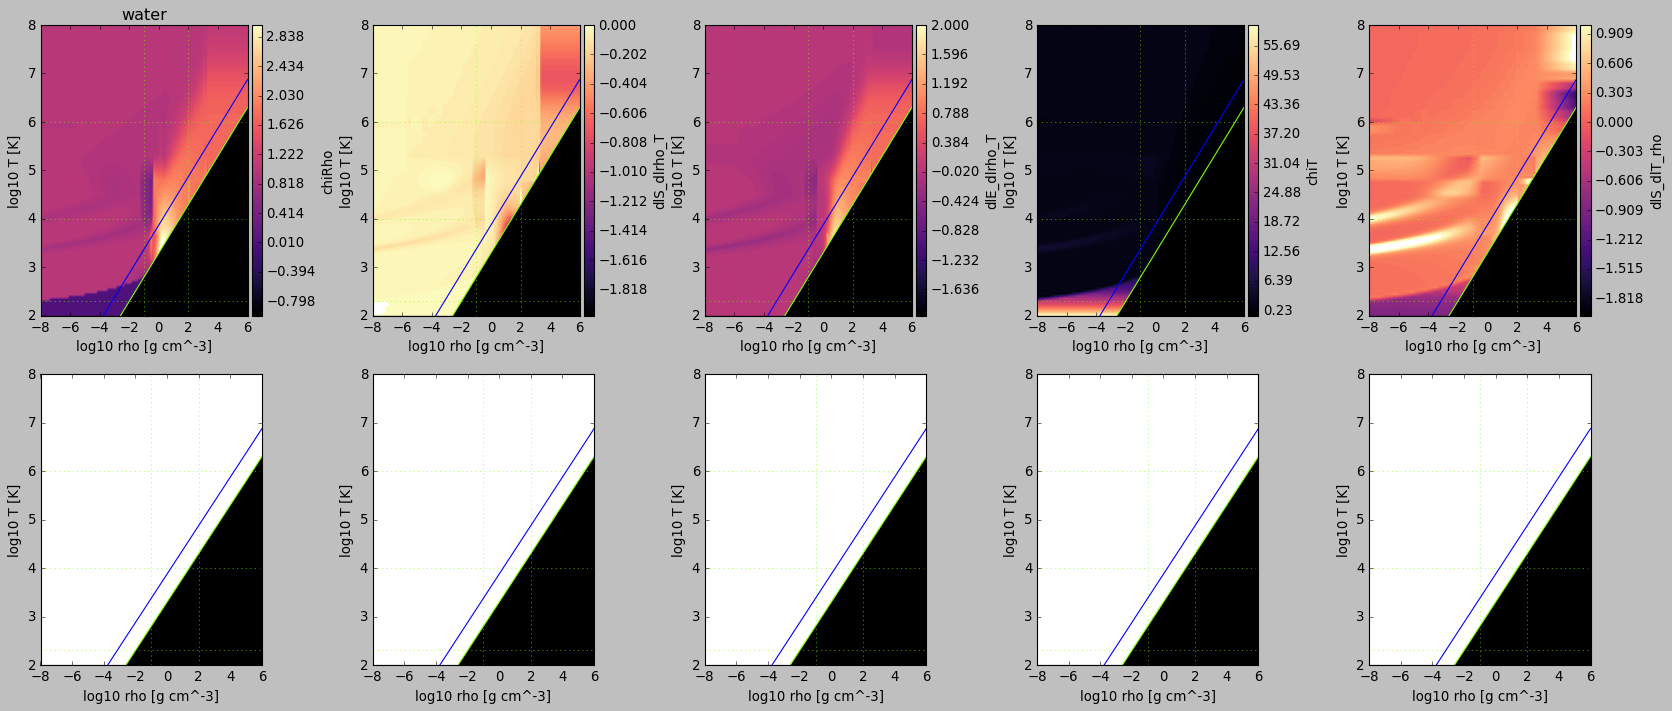

In [129]:
chiRho_vmin = -1
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -2
dlS_dlrho_T_vmax = 0
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -2
dlE_dlrho_T_vmax =2
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)

chiT_vmin = -1
chiT_vmax = 60
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = -2
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from cms_He table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(h2o.log10rhogrid, h2o.log10Tgrid, h2o.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(h2o.log10rhogrid, h2o.log10Tgrid, h2o.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(h2o.log10rhogrid, h2o.log10Tgrid, h2o.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(h2o.log10rhogrid, h2o.log10Tgrid, h2o.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(h2o.log10rhogrid, h2o.log10Tgrid, h2o.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')


'''
# row 1: interpolated finite difference quantities from cms_He table, with linearly smoothed edges of the QMD region (particularly over the horizontal line log10T = 6 and the vertical line log10rho = 2)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')
'''
for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(-1,color='#7FFF00',lw=0.5,ls=':')
    ax.axvline(2,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.3,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(6,color='#7FFF00',lw=0.5,ls=':')
    
    #to plot any contour log10Q = Q:
    # plot y = (x/2) + (12-Q)/2
    Qplot = 4.25
    ax.plot(np.linspace(-8,6,50), (1./2.)*np.linspace(-8,6,50) + (12-Qplot)/2, ls='-', color='b')

axes[0,0].set_title("water")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [121]:
MESA_cols_6to16(h2o,X=0,Y=0)

2.0
2.05
2.0999999999999996
2.1499999999999995
2.1999999999999993
2.249999999999999
2.299999999999999
2.3499999999999988
2.3999999999999986
2.4499999999999984
2.4999999999999982
2.549999999999998
2.599999999999998
2.6499999999999977
2.6999999999999975
2.7499999999999973
2.799999999999997
2.849999999999997
2.899999999999997
2.9499999999999966
2.9999999999999964
3.0499999999999963
3.099999999999996
3.149999999999996
3.1999999999999957
3.2499999999999956
3.2999999999999954
3.349999999999995
3.399999999999995
3.449999999999995
3.4999999999999947
3.5499999999999945
3.5999999999999943
3.649999999999994
3.699999999999994
3.749999999999994
3.7999999999999936
3.8499999999999934
3.8999999999999932
3.949999999999993
3.999999999999993
4.049999999999993
4.0999999999999925
4.149999999999992
4.199999999999992
4.249999999999992
4.299999999999992
4.349999999999992
4.3999999999999915
4.449999999999991
4.499999999999991
4.549999999999991
4.599999999999991
4.649999999999991
4.69999999999999
4.749999999999

In [ ]:
h2o.log10Qgrid = h2o.log10rhogrid - 2.*h2o.log10Tgrid + 12

write_MESA_table(h2o, './my_MESAformat_tables/mesa-h2o_100z00x.data',version=1, X=0.0, Z=1.0)

# pure rock table

In [133]:
infile = open('./my_Ztables/blended_rock.pkl','rb')
rock = pickle.load(infile)
infile.close()

rock.chiRho, rock.dlS_dlrho_T, rock.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(rock)
rock.chiT, rock.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(rock)


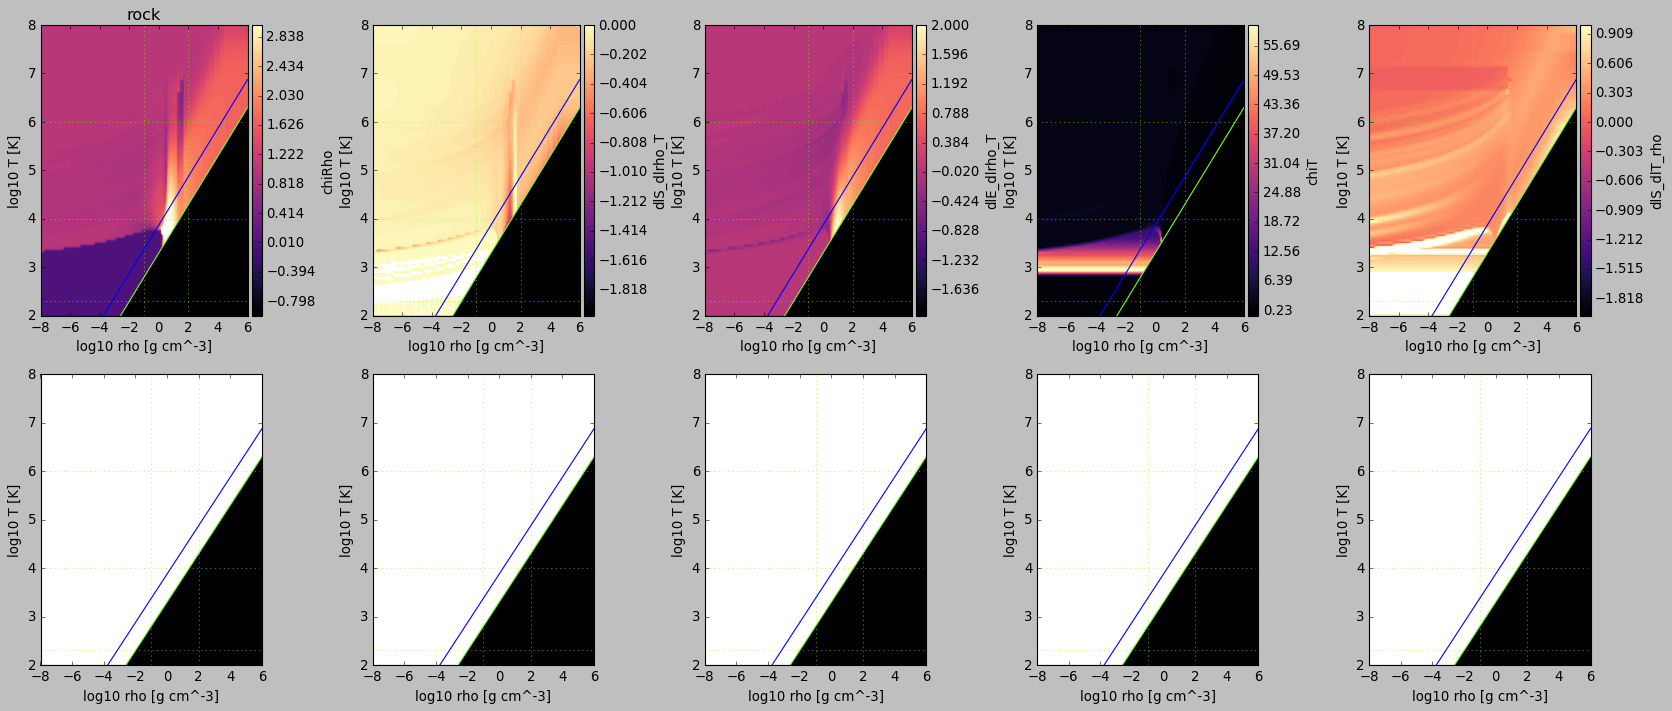

In [134]:
chiRho_vmin = -1
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -2
dlS_dlrho_T_vmax = 0
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -2
dlE_dlrho_T_vmax =2
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)

chiT_vmin = -1
chiT_vmax = 60
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = -2
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from cms_He table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(rock.log10rhogrid, rock.log10Tgrid, rock.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(rock.log10rhogrid, rock.log10Tgrid, rock.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(rock.log10rhogrid, rock.log10Tgrid, rock.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(rock.log10rhogrid, rock.log10Tgrid, rock.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(rock.log10rhogrid, rock.log10Tgrid, rock.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')


'''
# row 1: interpolated finite difference quantities from cms_He table, with linearly smoothed edges of the QMD region (particularly over the horizontal line log10T = 6 and the vertical line log10rho = 2)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')
'''
for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(-1,color='#7FFF00',lw=0.5,ls=':')
    ax.axvline(2,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.3,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(6,color='#7FFF00',lw=0.5,ls=':')
    
    #to plot any contour log10Q = Q:
    # plot y = (x/2) + (12-Q)/2
    Qplot = 4.25
    ax.plot(np.linspace(-8,6,50), (1./2.)*np.linspace(-8,6,50) + (12-Qplot)/2, ls='-', color='b')

axes[0,0].set_title("rock")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [135]:
MESA_cols_6to16(rock,X=0,Y=0)

2.0
2.05
2.0999999999999996
2.1499999999999995
2.1999999999999993
2.249999999999999
2.299999999999999
2.3499999999999988
2.3999999999999986
2.4499999999999984
2.4999999999999982
2.549999999999998
2.599999999999998
2.6499999999999977
2.6999999999999975
2.7499999999999973
2.799999999999997
2.849999999999997
2.899999999999997
2.9499999999999966
2.9999999999999964
3.0499999999999963
3.099999999999996
3.149999999999996
3.1999999999999957
3.2499999999999956
3.2999999999999954
3.349999999999995
3.399999999999995
3.449999999999995
3.4999999999999947
3.5499999999999945
3.5999999999999943
3.649999999999994
3.699999999999994
3.749999999999994
3.7999999999999936
3.8499999999999934
3.8999999999999932
3.949999999999993
3.999999999999993
4.049999999999993
4.0999999999999925
4.149999999999992
4.199999999999992
4.249999999999992
4.299999999999992
4.349999999999992
4.3999999999999915
4.449999999999991
4.499999999999991
4.549999999999991
4.599999999999991
4.649999999999991
4.69999999999999
4.749999999999

In [136]:
rock.log10Qgrid = rock.log10rhogrid - 2.*rock.log10Tgrid + 12

write_MESA_table(rock, './my_MESAformat_tables/mesa-rock_100z00x.data',version=1, X=0.0, Z=1.0)

# iron

In [137]:
infile = open('./my_Ztables/blended_iron.pkl','rb')
iron = pickle.load(infile)
infile.close()

iron.chiRho, iron.dlS_dlrho_T, iron.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(iron)
iron.chiT, iron.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(iron)


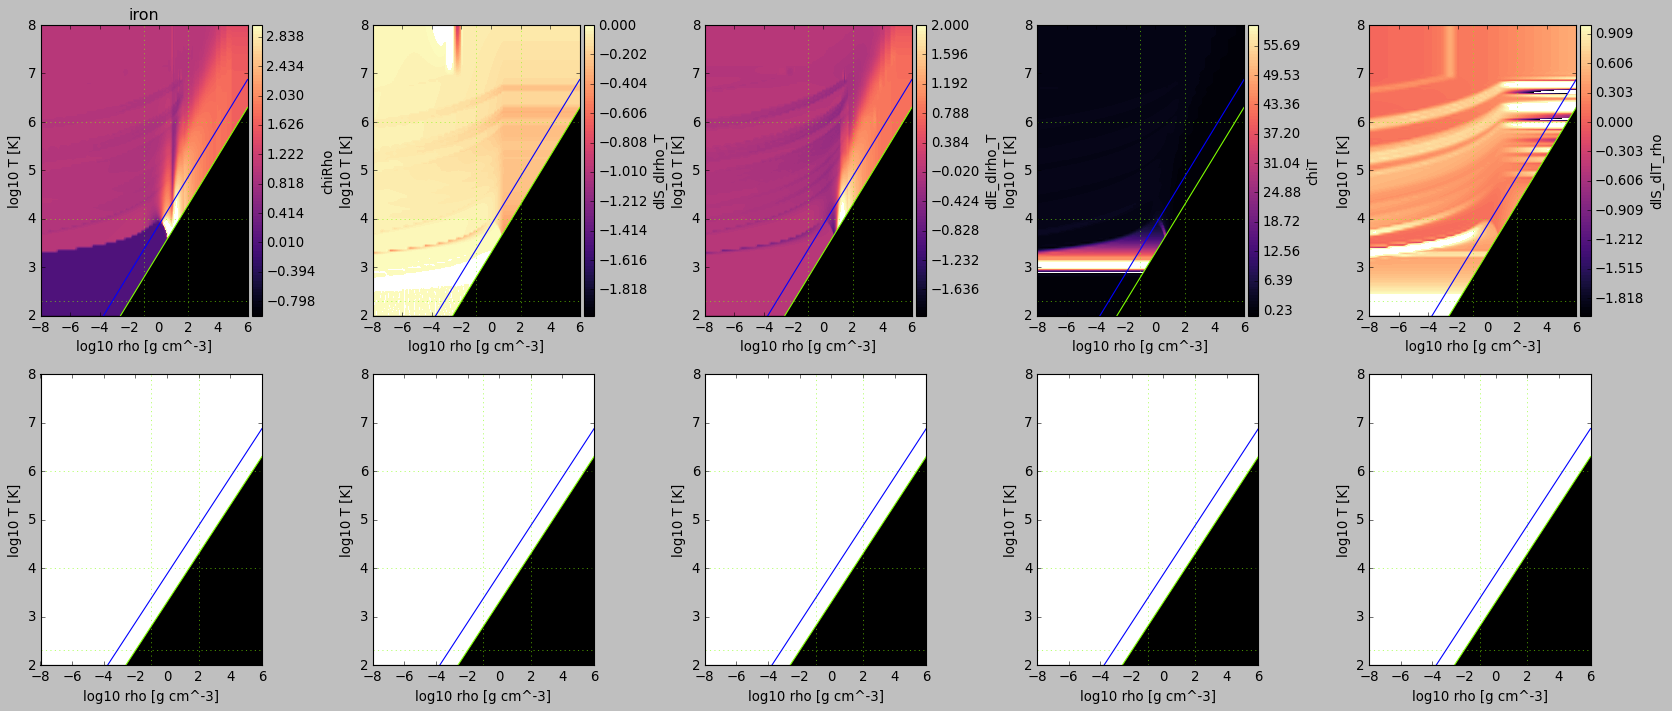

In [138]:
chiRho_vmin = -1
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -2
dlS_dlrho_T_vmax = 0
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -2
dlE_dlrho_T_vmax =2
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)

chiT_vmin = -1
chiT_vmax = 60
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = -2
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from cms_He table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(iron.log10rhogrid, iron.log10Tgrid, iron.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(iron.log10rhogrid, iron.log10Tgrid, iron.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(iron.log10rhogrid, iron.log10Tgrid, iron.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(iron.log10rhogrid, iron.log10Tgrid, iron.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(iron.log10rhogrid, iron.log10Tgrid, iron.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')


'''
# row 1: interpolated finite difference quantities from cms_He table, with linearly smoothed edges of the QMD region (particularly over the horizontal line log10T = 6 and the vertical line log10rho = 2)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')
'''
for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(-1,color='#7FFF00',lw=0.5,ls=':')
    ax.axvline(2,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.3,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(6,color='#7FFF00',lw=0.5,ls=':')
    
    #to plot any contour log10Q = Q:
    # plot y = (x/2) + (12-Q)/2
    Qplot = 4.25
    ax.plot(np.linspace(-8,6,50), (1./2.)*np.linspace(-8,6,50) + (12-Qplot)/2, ls='-', color='b')

axes[0,0].set_title("iron")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [139]:
MESA_cols_6to16(iron,X=0,Y=0)

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:21: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlT_P = -1. * table.chiT/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:22: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlP_T = 1./table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:24: RuntimeWarning: divide by zero encountered in divide
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:25: RuntimeWarning: divide by zero encountered in divide
  dlS_dlP_T = table.dlS_dlrho_T/table.chiRho


2.0
2.05
2.0999999999999996
2.1499999999999995
2.1999999999999993
2.249999999999999
2.299999999999999
2.3499999999999988
2.3999999999999986
2.4499999999999984
2.4999999999999982
2.549999999999998
2.599999999999998
2.6499999999999977
2.6999999999999975
2.7499999999999973
2.799999999999997
2.849999999999997
2.899999999999997
2.9499999999999966
2.9999999999999964
3.0499999999999963
3.099999999999996
3.149999999999996
3.1999999999999957
3.2499999999999956
3.2999999999999954
3.349999999999995
3.399999999999995
3.449999999999995
3.4999999999999947
3.5499999999999945
3.5999999999999943
3.649999999999994
3.699999999999994
3.749999999999994
3.7999999999999936
3.8499999999999934
3.8999999999999932
3.949999999999993
3.999999999999993
4.049999999999993
4.0999999999999925
4.149999999999992
4.199999999999992
4.249999999999992
4.299999999999992
4.349999999999992
4.3999999999999915
4.449999999999991
4.499999999999991
4.549999999999991
4.599999999999991
4.649999999999991
4.69999999999999
4.749999999999

In [163]:
iron.log10Qgrid = iron.log10rhogrid - 2.*iron.log10Tgrid + 12

write_MESA_table(iron, './my_MESAformat_tables/mesa-iron_100z00x.data',version=1, X=0.0, Z=1.0)

6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp -inf -1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp inf 1.0
6 Cp -inf -1.0
6 Cp -inf -1.0


# 50-50 water/rock

In [165]:
def blend_z1_z2(z1table, z2table, z1frac = 0.5):

    Z = 1.
    z2frac = Z - z1frac

    shared_log10Tgrid = z1table.log10Tgrid
    shared_log10Pgrid = z1table.log10Pgrid

    mixed_table = simple_table()
    mixed_table.X = 0
    mixed_table.Y = 0
    mixed_table.log10Tgrid = shared_log10Tgrid
    mixed_table.log10Pgrid = shared_log10Pgrid

    mixed_log10rhogrid = np.zeros_like(shared_log10Tgrid)
    mixed_log10Sgrid = np.zeros_like(shared_log10Tgrid)
    mixed_log10Ugrid = np.zeros_like(shared_log10Tgrid)

    Tarr = np.arange(2.,8.04,0.05)
    rhoarr = np.arange(-8.,6.04,0.05)

    for i, rho in enumerate(rhoarr):
        for j, T in enumerate(Tarr):
            
            rho_z1= 10**z1table.log10rhogrid[i,j]
            rho_z2 = 10**z2table.log10rhogrid[i,j]

            S_z1 = 10**z1table.log10Sgrid[i,j]
            S_z2 = 10**z2table.log10Sgrid[i,j]

            U_z1 = 10**z1table.log10Ugrid[i,j]
            U_z2 = 10**z2table.log10Ugrid[i,j]

            mixed_log10rhogrid[i,j] = np.log10(1./((z1frac/rho_z1) + (z2frac/rho_z2)))
            mixed_log10Sgrid[i,j] = np.log10(z1frac*S_z1 + z2frac*S_z2)
            mixed_log10Ugrid[i,j] = np.log10(z1frac*U_z1 + z2frac*U_z2)
    
    
    mixed_table.log10rhogrid = mixed_log10rhogrid
    mixed_table.log10Sgrid = mixed_log10Sgrid
    mixed_table.log10Ugrid = mixed_log10Ugrid
    
    return mixed_table


In [166]:
infile = open('./my_Ztables/blended_h2o.pkl','rb')
h2o_toblend = pickle.load(infile)
infile.close()


In [167]:
infile = open('./my_Ztables/blended_rock.pkl','rb')
rock_toblend = pickle.load(infile)
infile.close()


In [168]:
rock_water = blend_z1_z2(z1table=h2o_toblend, z2table=rock_toblend, z1frac = 0.5)

In [169]:
rock_water.chiRho, rock_water.dlS_dlrho_T, rock_water.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(rock_water)
rock_water.chiT, rock_water.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(rock_water)


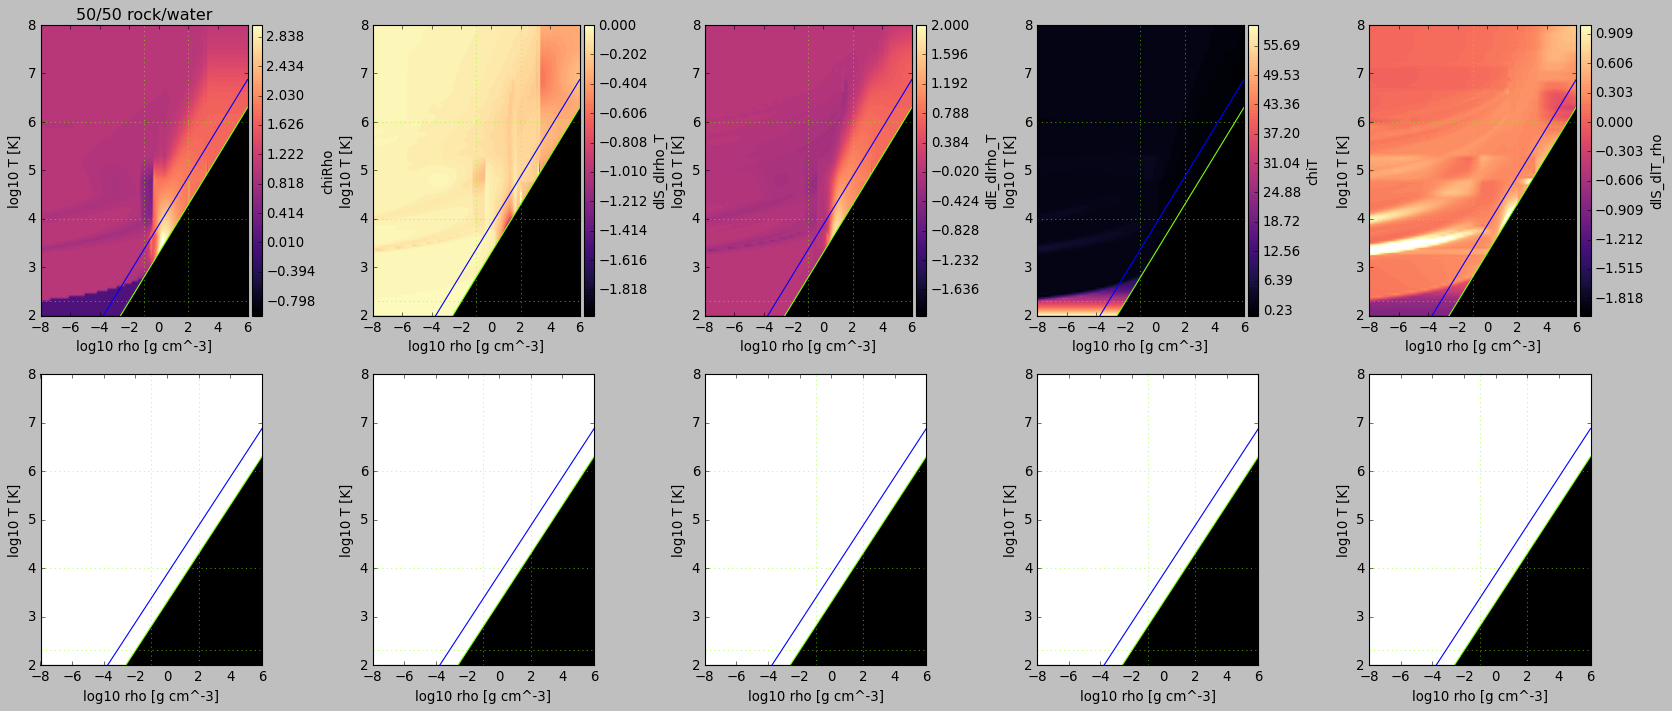

In [170]:
chiRho_vmin = -1
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -2
dlS_dlrho_T_vmax = 0
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -2
dlE_dlrho_T_vmax =2
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)

chiT_vmin = -1
chiT_vmax = 60
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = -2
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from cms_He table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')


'''
# row 1: interpolated finite difference quantities from cms_He table, with linearly smoothed edges of the QMD region (particularly over the horizontal line log10T = 6 and the vertical line log10rho = 2)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')
'''
for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(-1,color='#7FFF00',lw=0.5,ls=':')
    ax.axvline(2,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.3,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(6,color='#7FFF00',lw=0.5,ls=':')
    
    #to plot any contour log10Q = Q:
    # plot y = (x/2) + (12-Q)/2
    Qplot = 4.25
    ax.plot(np.linspace(-8,6,50), (1./2.)*np.linspace(-8,6,50) + (12-Qplot)/2, ls='-', color='b')

axes[0,0].set_title("50/50 rock/water")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [171]:
MESA_cols_6to16(rock_water,X=0,Y=0)

2.0
2.05
2.0999999999999996
2.1499999999999995
2.1999999999999993
2.249999999999999
2.299999999999999
2.3499999999999988
2.3999999999999986
2.4499999999999984
2.4999999999999982
2.549999999999998
2.599999999999998
2.6499999999999977
2.6999999999999975
2.7499999999999973
2.799999999999997
2.849999999999997
2.899999999999997
2.9499999999999966
2.9999999999999964
3.0499999999999963
3.099999999999996
3.149999999999996
3.1999999999999957
3.2499999999999956
3.2999999999999954
3.349999999999995
3.399999999999995
3.449999999999995
3.4999999999999947
3.5499999999999945
3.5999999999999943
3.649999999999994
3.699999999999994
3.749999999999994
3.7999999999999936
3.8499999999999934
3.8999999999999932
3.949999999999993
3.999999999999993
4.049999999999993
4.0999999999999925
4.149999999999992
4.199999999999992
4.249999999999992
4.299999999999992
4.349999999999992
4.3999999999999915
4.449999999999991
4.499999999999991
4.549999999999991
4.599999999999991
4.649999999999991
4.69999999999999
4.749999999999

In [172]:
rock_water.log10Qgrid = rock_water.log10rhogrid - 2.*rock_water.log10Tgrid + 12

write_MESA_table(rock_water, './my_MESAformat_tables/mesa-rock_water_100z00x.data',version=1, X=0.0, Z=1.0)

# XYZ mixture tables, 50/50 rock-water

In [177]:
print(type(rock_water))
rock_water.atomic_number = 1
rock_water.mass_number= 1

<class '__main__.simple_table'>


In [178]:
rock_water_PT = interpolated_PTtable(rock_water)

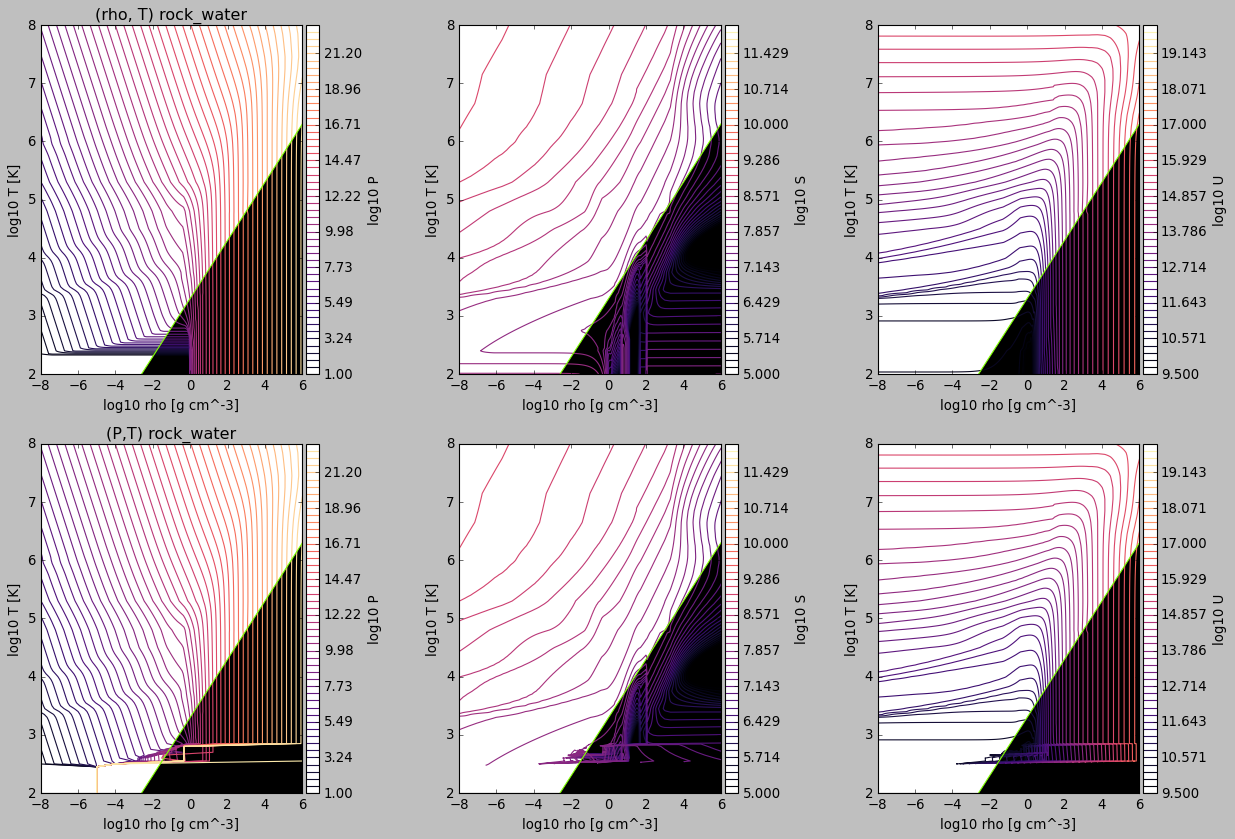

In [183]:
log10Plevels = np.linspace(1,23,50)
log10Pvmin = 0.
log10Pvmax = 24

log10Slevels = np.linspace(5,12,50)
log10Svmin = 5
log10Svmax = 12

log10Ulevels = np.linspace(9.5,20,50)
log10Uvmin = 9.5
log10Uvmax = 20

log10rholevels = np.linspace(-8,6,50)
log10rhovmin = -8.
log10rhovmax = 6


fig, axes = plt.subplots(2,3,figsize=(18,12))

# row 0: original (rho, T) version of bln_H table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: re-based to (P,T)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contour(rock_water_PT.log10rhogrid, rock_water_PT.log10Tgrid, rock_water_PT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contour(rock_water_PT.log10rhogrid, rock_water_PT.log10Tgrid, rock_water_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contour(rock_water_PT.log10rhogrid, rock_water_PT.log10Tgrid, rock_water_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')


for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')

  
axes[0,0].set_title("(rho, T) rock_water")
axes[1,0].set_title("(P,T) rock_water")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [190]:
#Xarr = np.arange(0.1,1.0,0.1)
Xarr = np.atleast_1d(np.array((0.0)))
Zarr = np.arange(0.1,1.0,0.1)

for i, xi in enumerate(Xarr):
    for k, zi in enumerate(Zarr):

        if (xi + zi) > 1.0:
            continue
        else:

            yi = 1. - (xi + zi)
    
            print(xi, yi, zi)
            
            mixed_XYZ = add_mixing_terms(H_PTtable=bln_H_PT, He_PTtable=cms_He_PT, Z_PTtable=rock_water_PT, X=xi, Y=yi, HG23path="/Users/emily/Documents/astro/giant_planets/MESA_EoS/HG23_Vmix_Smix_Umix.csv")
            mixed_XYZ.log10Sgrid[~np.isfinite(mixed_XYZ.log10Sgrid)] = 0.
    
        
            start = time.time()
            if (xi >= yi) & (xi >= zi):
                mixed_XYZ_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=bln_H.log10Pgrid, X=xi, Y=yi)
            elif (yi > xi) & (yi >= zi):
                mixed_XYZ_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=cms_He.log10Pgrid, X=xi, Y=yi)
            else:
                mixed_XYZ_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=rock_water.log10Pgrid, X=xi, Y=yi)
            end = time.time()
            print((end-start)/60.)
    
            mixed_XYZ_rhoT.chiRho, mixed_XYZ_rhoT.dlS_dlrho_T, mixed_XYZ_rhoT.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(mixed_XYZ_rhoT)
            mixed_XYZ_rhoT.chiT, mixed_XYZ_rhoT.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(mixed_XYZ_rhoT)
    
            MESA_cols_6to16(mixed_XYZ_rhoT, X=Xarr[i],Y=1.-(Xarr[i]+Zarr[k]))
            
            savefilename = './my_MESAformat_tables/mesa-planetblend_{0}0z{1}0x.data'.format(str(np.round(zi,1))[-1], str(np.round(xi,1))[-1])
            print(savefilename)
            write_MESA_table(mixed_XYZ_rhoT, savefilename,version=1, X=xi, Z=zi)
        

0.0 0.9 0.1
3.362689117590586
2.0
2.05
2.0999999999999996
2.1499999999999995
2.1999999999999993
2.249999999999999
2.299999999999999
2.3499999999999988
2.3999999999999986
2.4499999999999984
2.4999999999999982
2.549999999999998
2.599999999999998
2.6499999999999977
2.6999999999999975
2.7499999999999973
2.799999999999997
2.849999999999997
2.899999999999997
2.9499999999999966
2.9999999999999964
3.0499999999999963
3.099999999999996
3.149999999999996
3.1999999999999957
3.2499999999999956
3.2999999999999954
3.349999999999995
3.399999999999995
3.449999999999995
3.4999999999999947
3.5499999999999945
3.5999999999999943
3.649999999999994
3.699999999999994
3.749999999999994
3.7999999999999936
3.8499999999999934
3.8999999999999932
3.949999999999993
3.999999999999993
4.049999999999993
4.0999999999999925
4.149999999999992
4.199999999999992
4.249999999999992
4.299999999999992
4.349999999999992
4.3999999999999915
4.449999999999991
4.499999999999991
4.549999999999991
4.599999999999991
4.649999999999991
4

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:21: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlT_P = -1. * table.chiT/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:22: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlP_T = 1./table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:24: RuntimeWarning: divide by zero encountered in divide
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:24: RuntimeWarning: invalid value encountered in multiply
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:25: RuntimeWarning: invalid value encountered in divide
  dlS_dlP_T = table.dlS_dlrho_T/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp

2.0
2.05
2.0999999999999996
2.1499999999999995
2.1999999999999993
2.249999999999999
2.299999999999999
2.3499999999999988
2.3999999999999986
2.4499999999999984
2.4999999999999982
2.549999999999998
2.599999999999998
2.6499999999999977
2.6999999999999975
2.7499999999999973
2.799999999999997
2.849999999999997
2.899999999999997
2.9499999999999966
2.9999999999999964
3.0499999999999963
3.099999999999996
3.149999999999996
3.1999999999999957
3.2499999999999956
3.2999999999999954
3.349999999999995
3.399999999999995
3.449999999999995
3.4999999999999947
3.5499999999999945
3.5999999999999943
3.649999999999994
3.699999999999994
3.749999999999994
3.7999999999999936
3.8499999999999934
3.8999999999999932
3.949999999999993
3.999999999999993
4.049999999999993
4.0999999999999925
4.149999999999992
4.199999999999992
4.249999999999992
4.299999999999992
4.349999999999992
4.3999999999999915
4.449999999999991
4.499999999999991
4.549999999999991
4.599999999999991
4.649999999999991
4.69999999999999
4.749999999999

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:21: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlT_P = -1. * table.chiT/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:22: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlP_T = 1./table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:24: RuntimeWarning: divide by zero encountered in divide
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:24: RuntimeWarning: invalid value encountered in multiply
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:25: RuntimeWarning: invalid value encountered in divide
  dlS_dlP_T = table.dlS_dlrho_T/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp

2.0
2.05
2.0999999999999996
2.1499999999999995
2.1999999999999993
2.249999999999999
2.299999999999999
2.3499999999999988
2.3999999999999986
2.4499999999999984
2.4999999999999982
2.549999999999998
2.599999999999998
2.6499999999999977
2.6999999999999975
2.7499999999999973
2.799999999999997
2.849999999999997
2.899999999999997
2.9499999999999966
2.9999999999999964
3.0499999999999963
3.099999999999996
3.149999999999996
3.1999999999999957
3.2499999999999956
3.2999999999999954
3.349999999999995
3.399999999999995
3.449999999999995
3.4999999999999947
3.5499999999999945
3.5999999999999943
3.649999999999994
3.699999999999994
3.749999999999994
3.7999999999999936
3.8499999999999934
3.8999999999999932
3.949999999999993
3.999999999999993
4.049999999999993
4.0999999999999925
4.149999999999992
4.199999999999992
4.249999999999992
4.299999999999992
4.349999999999992
4.3999999999999915
4.449999999999991
4.499999999999991
4.549999999999991
4.599999999999991
4.649999999999991
4.69999999999999
4.749999999999

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:21: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlT_P = -1. * table.chiT/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:22: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlP_T = 1./table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:24: RuntimeWarning: divide by zero encountered in divide
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:24: RuntimeWarning: invalid value encountered in multiply
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:25: RuntimeWarning: invalid value encountered in divide
  dlS_dlP_T = table.dlS_dlrho_T/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp

2.0
2.05
2.0999999999999996
2.1499999999999995
2.1999999999999993
2.249999999999999
2.299999999999999
2.3499999999999988
2.3999999999999986
2.4499999999999984
2.4999999999999982
2.549999999999998
2.599999999999998
2.6499999999999977
2.6999999999999975
2.7499999999999973
2.799999999999997
2.849999999999997
2.899999999999997
2.9499999999999966
2.9999999999999964
3.0499999999999963
3.099999999999996
3.149999999999996
3.1999999999999957
3.2499999999999956
3.2999999999999954
3.349999999999995
3.399999999999995
3.449999999999995
3.4999999999999947
3.5499999999999945
3.5999999999999943
3.649999999999994
3.699999999999994
3.749999999999994
3.7999999999999936
3.8499999999999934
3.8999999999999932
3.949999999999993
3.999999999999993
4.049999999999993
4.0999999999999925
4.149999999999992
4.199999999999992
4.249999999999992
4.299999999999992
4.349999999999992
4.3999999999999915
4.449999999999991
4.499999999999991
4.549999999999991
4.599999999999991
4.649999999999991
4.69999999999999
4.749999999999

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:21: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlT_P = -1. * table.chiT/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:22: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlP_T = 1./table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:24: RuntimeWarning: divide by zero encountered in divide
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:24: RuntimeWarning: invalid value encountered in multiply
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_30758/483941788.py:25: RuntimeWarning: invalid value encountered in divide
  dlS_dlP_T = table.dlS_dlrho_T/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp

2.0
2.05
2.0999999999999996
2.1499999999999995
2.1999999999999993
2.249999999999999
2.299999999999999
2.3499999999999988
2.3999999999999986
2.4499999999999984
2.4999999999999982
2.549999999999998
2.599999999999998
2.6499999999999977
2.6999999999999975
2.7499999999999973
2.799999999999997
2.849999999999997
2.899999999999997
2.9499999999999966
2.9999999999999964
3.0499999999999963
3.099999999999996
3.149999999999996
3.1999999999999957
3.2499999999999956
3.2999999999999954
3.349999999999995
3.399999999999995
3.449999999999995
3.4999999999999947
3.5499999999999945
3.5999999999999943
3.649999999999994
3.699999999999994
3.749999999999994
3.7999999999999936
3.8499999999999934
3.8999999999999932
3.949999999999993
3.999999999999993
4.049999999999993
4.0999999999999925
4.149999999999992
4.199999999999992
4.249999999999992
4.299999999999992
4.349999999999992
4.3999999999999915
4.449999999999991
4.499999999999991
4.549999999999991
4.599999999999991
4.649999999999991
4.69999999999999
4.749999999999